# Week 10 Unsupervised Learning Techniques: Clustering Assignment
by Team Apex: Pradeep Anand Mohanasundaram, Mythily Kanagaraj, Rahul Naidu Maliga & Kristin Manthey

## Part 1: Data Loading, Exploration, and Preprocessing

In this first part of the assignment, we lay the foundation for the clustering analysis by preparing three datasets: one synthetic dataset and two real-world datasets: the Mall Customer dataset and the Wine Quality dataset. This section is critical, as effective clustering heavily depends on well-prepared data.

For each dataset, we follow a structured approach:
- Load the dataset and examine its shape and structure
- Explore the data visually and statistically to understand its distributions and relationships
- Identify and address missing values or inconsistencies
- Standardize or normalize features to ensure that scale differences do not bias clustering results
- Select relevant features for clustering and justify those decisions

This careful and methodical preprocessing ensures that the clustering algorithms applied later will perform optimally and yield meaningful results.

### 1.1 Synthetic Dataset: Generation and Exploration

We start with a synthetic dataset created using the `make_blobs` function from `sklearn.datasets`. This dataset contains 300 samples grouped into 4 clusters in a 2-dimensional space. The `cluster_std` parameter is set to 0.8 to ensure the clusters are compact but still visually distinct.

This synthetic data serves as a controlled benchmark for validating clustering algorithms, as the underlying structure is known in advance. The `Cluster_Label` column is included for visualization and exploratory purposes only and is not used in any unsupervised learning procedure.

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Generate synthetic dataset (following assignment instructions)
X_synthetic, y_true = make_blobs(
    n_samples=300,
    centers=4,
    n_features=2,
    random_state=42,
    cluster_std=0.8
)

# Convert to DataFrame
df_synth = pd.DataFrame(X_synthetic, columns=['Feature_1', 'Feature_2'])
df_synth['Cluster_Label'] = y_true  # For visualization only

# Shape and preview
print("Shape of dataset:", df_synth.shape)
df_synth.head()

Shape of dataset: (300, 3)


,Feature_1,Feature_2,Cluster_Label
0,-9.205816,6.643647,3
1,-9.526658,7.015878,3
2,-1.851162,8.037611,0
3,-7.053772,-6.001088,2
4,-10.468827,6.517054,3


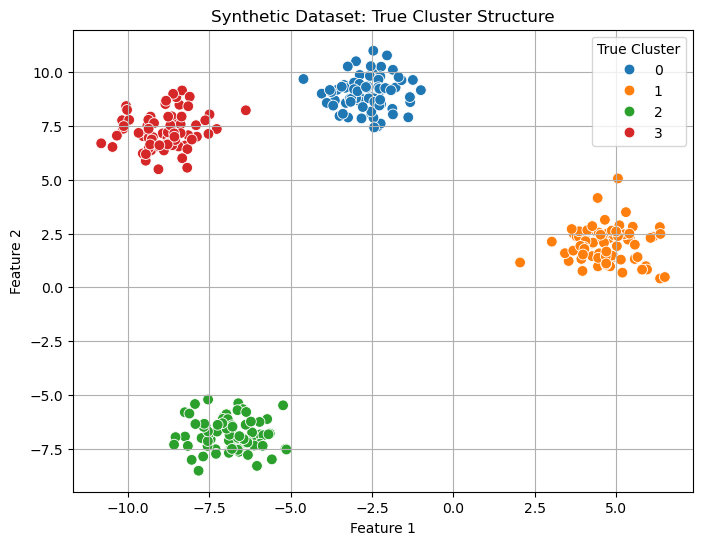

In [3]:
# Visualize the generated synthetic clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_synth, x='Feature_1', y='Feature_2', hue='Cluster_Label', palette='tab10', s=60)
plt.title('Synthetic Dataset: True Cluster Structure')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='True Cluster')
plt.grid(True)
plt.show()

The synthetic dataset contains 300 samples, each with two continuous features: `Feature_1` and `Feature_2`. Additionally, a `Cluster_Label` column is included to represent the true cluster assignment from `make_blobs`, which is only used here for initial exploration and visualization.

The tabular preview confirms the expected structure and dimensions of the dataset. The scatterplot further illustrates that the samples are grouped into four compact and clearly separable clusters, which makes this dataset well-suited for demonstrating clustering algorithms such as K-means. Importantly, the true labels are not used in unsupervised learning and are shown here solely to validate the initial structure.

**Standardization for Clustering Algorithms**

Although the synthetic dataset is clearly structured and the clusters are well-separated, we still apply feature scaling using `StandardScaler`. This is crucial because many clustering algorithms, including hierarchical clustering and DBSCAN, are distance-based — meaning they rely on the relative scale of the input features.

Standardizing ensures that both `Feature_1` and `Feature_2` contribute equally to distance calculations, preventing any bias caused by differing value ranges.

In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the synthetic dataset
scaler = StandardScaler()
synthetic_scaled = scaler.fit_transform(df_synth[['Feature_1', 'Feature_2']])
synthetic_scaled_df = pd.DataFrame(synthetic_scaled, columns=['Feature_1', 'Feature_2'])

### 1.2 Mall Customer Dataset: Loading and Initial Exploration

The Mall Customer dataset provides demographic and spending information for a set of customers. It is a common example for applying clustering algorithms, especially for customer segmentation tasks.

In this step, we load the dataset and perform basic exploration to understand its structure. We examine the shape, data types, missing values, and distributions of key variables.


In [10]:
import os

# Get the current working directory
current_directory = os.getcwd()
print(current_directory)

/Users/kristin


In [12]:
# Load the Mall Customer dataset
mall_data = pd.read_csv('/Users/kristin/Library/CloudStorage/OneDrive-UniversityofSouthFlorida/01_Classes 2nd Semester/02_Machine Learning/10_Week/Mall_Customers.csv')

# Preview the dataset
print("Shape of dataset:", mall_data.shape)
mall_data.head()

Shape of dataset: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


The dataset consists of 200 customers and five columns. Among them, `CustomerID` is an identifier and will be excluded from clustering. The three numerical variables of interest are `Age`, `Annual Income (k$)`, and `Spending Score (1-100)`.

The `Gender` variable is categorical and could be considered for clustering if encoded properly. However, for our baseline clustering implementation, we begin with the three numerical features. This allows us to focus on continuous traits that are typically better suited for distance-based clustering algorithms like K-means.

#### 1.2.1 Data Quality Check and Distribution Visualization
Before preprocessing, we examine the dataset for missing values and explore the distribution of key numerical features. This step ensures that the data is clean and helps us identify potential skewness or outliers that could affect clustering performance.

Missing values per column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


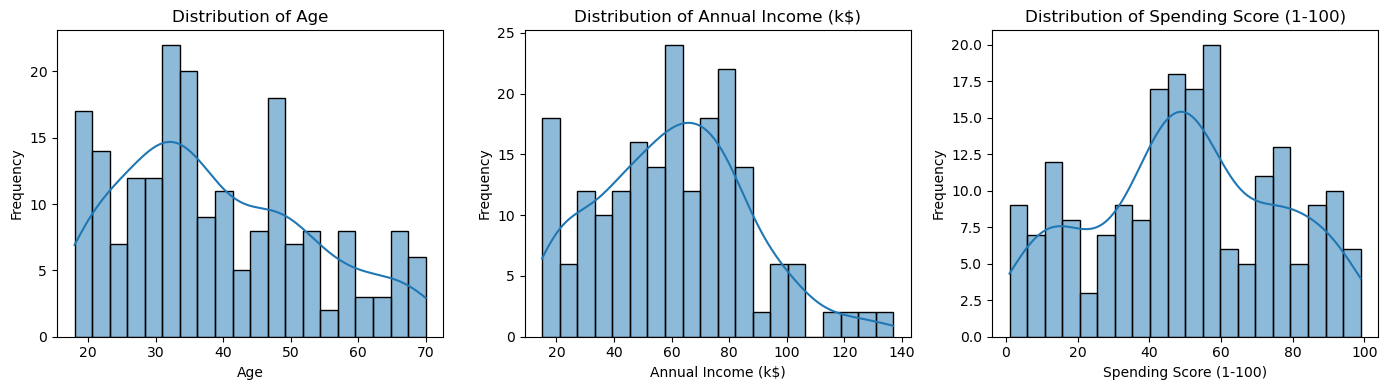

In [14]:
# Check for missing values
missing = mall_data.isnull().sum()
print("Missing values per column:\n", missing)

# Select numeric columns of interest
mall_numerical = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Plot distributions
plt.figure(figsize=(14, 4))
for idx, col in enumerate(mall_numerical.columns):
    plt.subplot(1, 3, idx + 1)
    sns.histplot(mall_numerical[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

There are no missing values in the dataset, so no imputation is necessary.

The univariate distributions indicate that `Age` and `Annual Income (k$)` are moderately skewed, with the latter showing a concentration of customers around the $60k–$80k range. `Spending Score (1–100)` appears more evenly distributed, with two slight peaks suggesting the presence of underlying customer segments.

These patterns reinforce the suitability of this dataset for clustering, particularly when identifying consumer profiles based on spending behavior and income. Prior to clustering, it is important to normalize these features to mitigate the influence of scale differences.

#### 1.2.2 Feature Relationships

To further understand the relationships between features, we compute a correlation matrix and visualize it using a heatmap. We also use a pairplot to display pairwise scatterplots and marginal distributions.

These visualizations help us assess potential multicollinearity, clustering patterns, and overall variable interaction. Understanding these relationships provides valuable insights before applying any clustering technique.

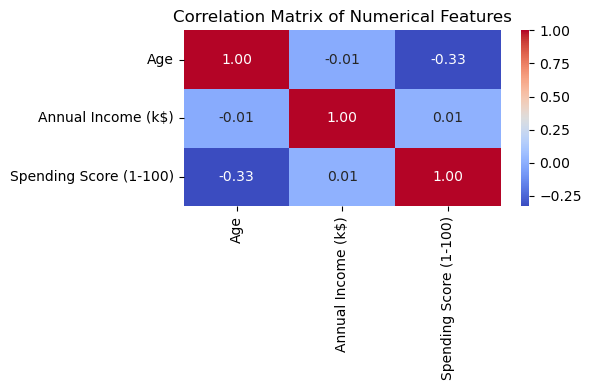

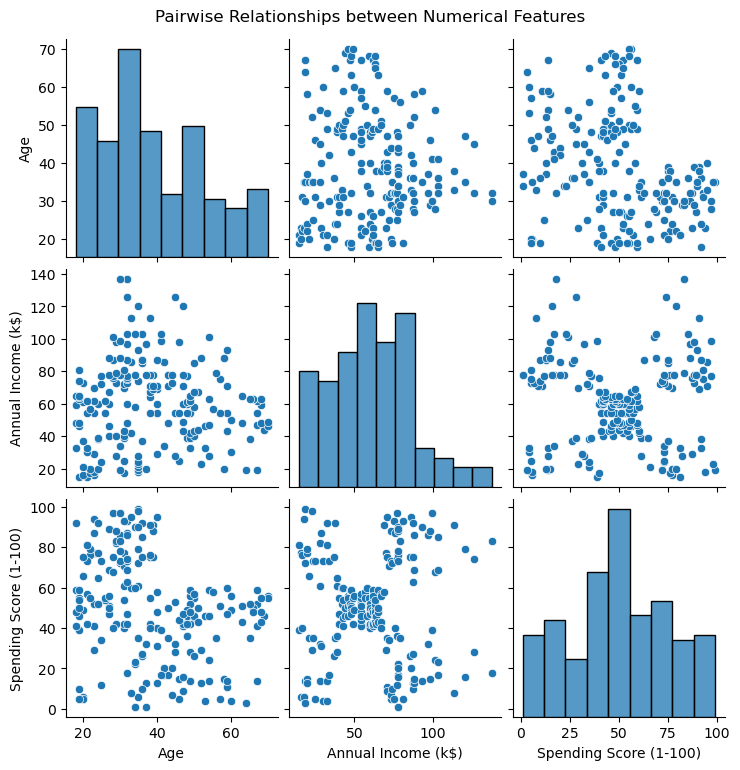

In [16]:
# Define numeric features
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(mall_data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Pairplot (scatterplot matrix)
sns.pairplot(mall_data[numerical_cols])
plt.suptitle('Pairwise Relationships between Numerical Features', y=1.02)
plt.show()

The correlation matrix reveals a weak negative relationship between `Age` and `Spending Score (1–100)` (r = –0.33), suggesting that younger customers may spend more. `Annual Income (k$)` shows virtually no linear correlation with either of the other two variables.

The pairplot further supports this finding by showing diffuse scatter patterns between most variable pairs. However, there is some visible clustering structure, especially between `Annual Income (k$)` and `Spending Score (1–100)`, where multiple groupings of customers appear to emerge. This confirms the potential for meaningful segmentation using clustering algorithms.

#### 1.2.3 Feature Selection and Standardization

To prepare the data for clustering, we first select relevant features. We exclude `CustomerID` as it is a unique identifier and does not carry behavioral meaning. While `Gender` could be considered with proper encoding, we focus on numerical features for this baseline clustering.

We select the following three variables for clustering:
- `Age`
- `Annual Income (k$)`
- `Spending Score (1–100)`

Since clustering algorithms like K-means rely on distance metrics, it is essential to standardize features to avoid bias introduced by differing scales. We apply z-score standardization using `StandardScaler` from `sklearn.preprocessing`.

In [18]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for clustering
mall_selected = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize features
scaler = StandardScaler()
mall_scaled = scaler.fit_transform(mall_selected)

# Convert to DataFrame for inspection
mall_scaled_df = pd.DataFrame(mall_scaled, columns=mall_selected.columns)

# Preview scaled data
mall_scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


The output confirms that the selected features have been successfully standardized. Each variable now has a mean of approximately 0 and a standard deviation of 1.

This transformation prevents features with larger scales (e.g., income) from dominating distance calculations in clustering algorithms. The dataset is now ready for the application of K-means clustering.

### 1.3 Wine Quality Dataset: Loading and Initial Exploration

The Wine Quality dataset contains physicochemical measurements of red wine samples, along with a quality score assigned by human tasters. This dataset is widely used in machine learning to explore relationships between chemical properties and perceived quality.

We begin by loading the dataset and examining its basic structure.

In [20]:
# Load the wine quality dataset
wine_data = pd.read_csv('/Users/kristin/Library/CloudStorage/OneDrive-UniversityofSouthFlorida/01_Classes 2nd Semester/02_Machine Learning/10_Week/Datasets Wine/winequality-red.csv', sep=';')

# Check shape and preview
print("Shape of dataset:", wine_data.shape)
wine_data.head()

Shape of dataset: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The dataset consists of 1,599 samples and 12 columns. Each row represents a red wine sample, described by 11 physicochemical properties (e.g., acidity, sugar, pH, alcohol) and one sensory quality score (`quality`), which is an ordinal rating given by human tasters on a scale typically ranging from 0 to 10.

The variables are all numerical, making this dataset well-suited for distance-based clustering. Our analysis will focus on identifying meaningful groupings of wines based on their chemical characteristics.

#### 1.3.1 Data Quality Check and Distribution Visualization

We begin by checking for missing values in the dataset, then explore the distribution of each numerical variable. This helps ensure the data is clean and allows us to assess the variability, skewness, and potential outliers in each feature.

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


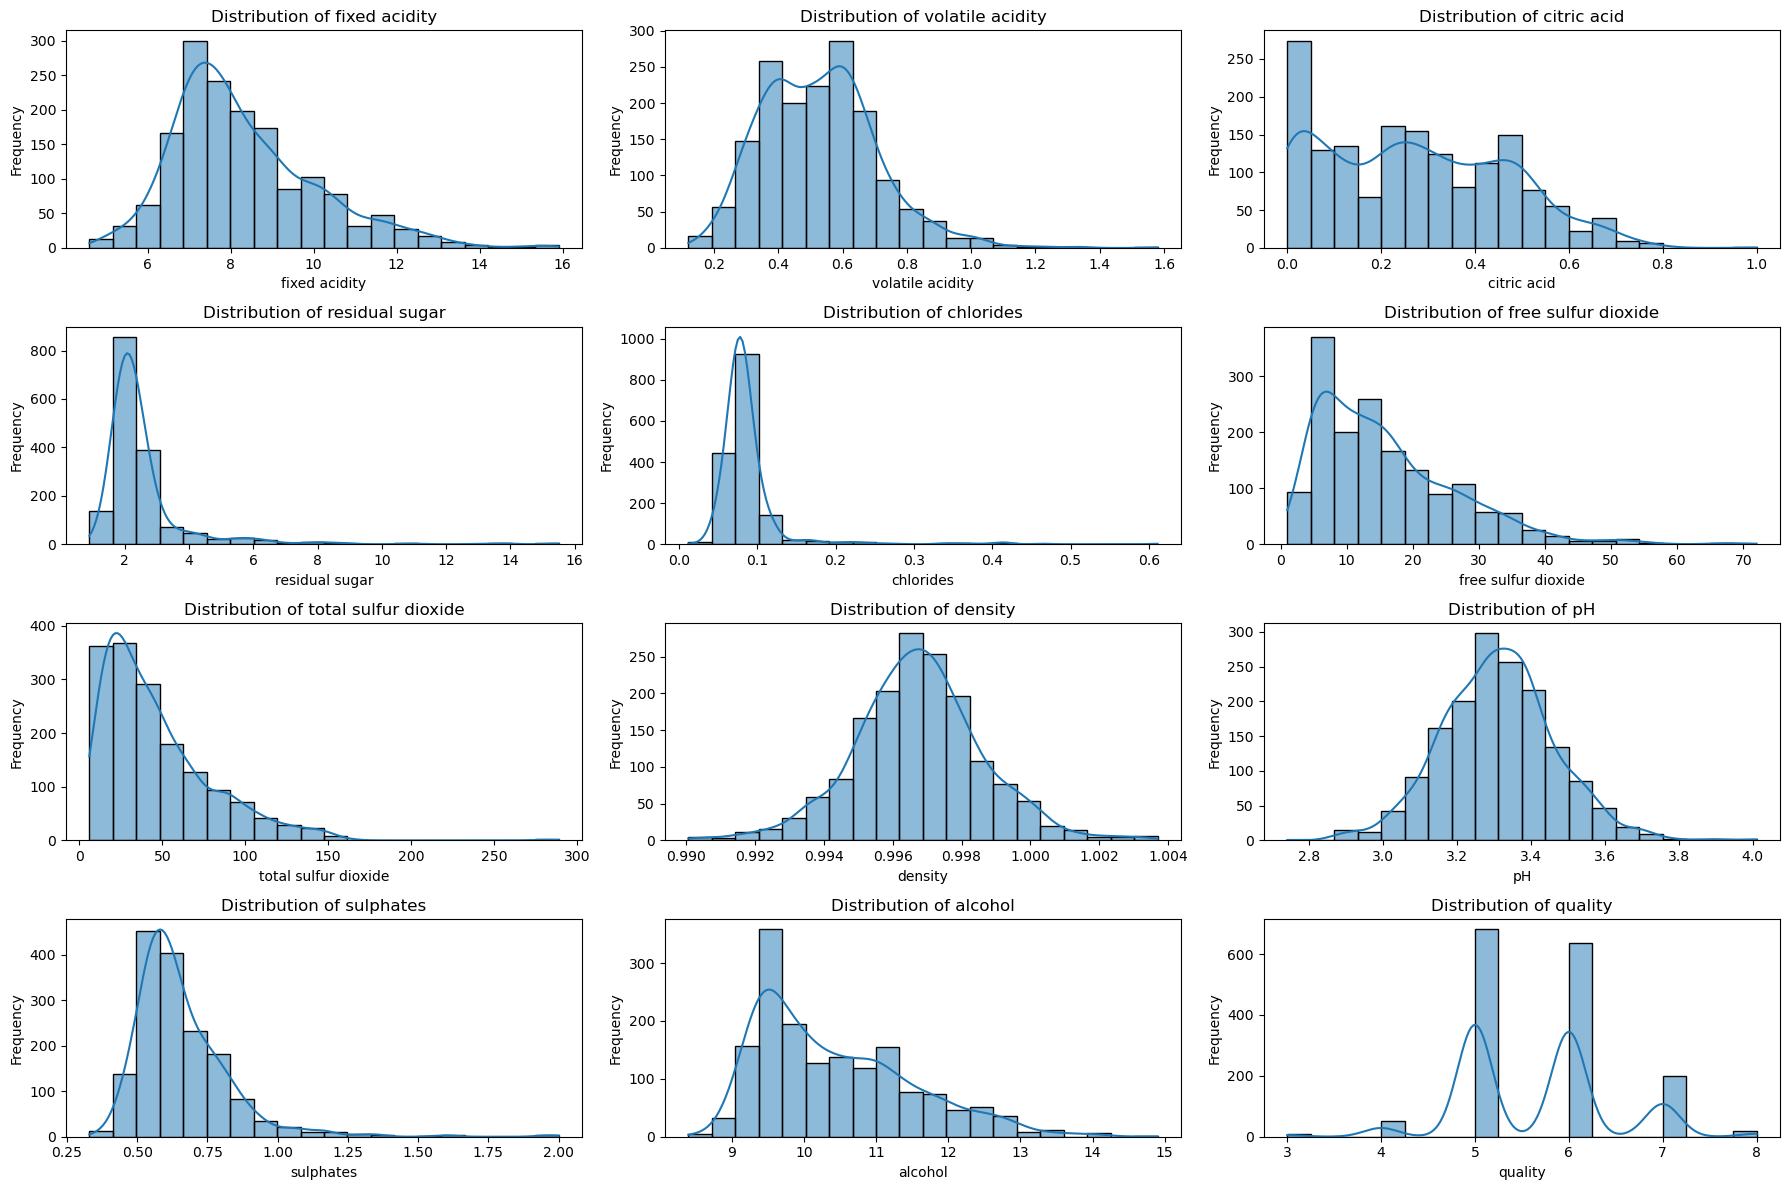

In [22]:
# Check for missing values
missing_wine = wine_data.isnull().sum()
print("Missing values per column:\n", missing_wine)

# Plot distributions for all variables
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))
for idx, col in enumerate(wine_data.columns):
    plt.subplot(4, 3, idx + 1)
    sns.histplot(wine_data[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

There are no missing values in the dataset, so no imputation is necessary.

The univariate distributions show that most variables are right-skewed, particularly `residual sugar`, `chlorides`, `free sulfur dioxide`, and `alcohol`. Others, like `pH`, appear more normally distributed. The `quality` variable is discrete and approximately bimodal, with most ratings concentrated around 5 and 6.

These characteristics suggest that feature scaling will be necessary, and clustering based on the raw chemical values may uncover distinct profiles of wine that correspond to different quality scores or production styles.

#### 1.3.2 Feature Relationships

Next, we explore how the numerical features relate to one another using a correlation matrix and pairplot. These tools help us identify strong linear relationships, detect multicollinearity, and spot patterns that may influence cluster formation.

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(wine_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Wine Features')
plt.tight_layout()
plt.show()

# Optional: pairplot (this may take time due to high dimensionality)
sns.pairplot(wine_data)
plt.suptitle('Pairwise Relationships between Wine Features', y=1.02)
plt.show()

The correlation matrix shows several noteworthy relationships among the wine features:

- `citric acid` and `fixed acidity` are moderately positively correlated (r = 0.67), suggesting a shared chemical basis.
- `density` is positively correlated with both `fixed acidity` (r = 0.67) and `residual sugar` (r = 0.36), which makes sense chemically since sugar and acid contribute to overall density.
- `free sulfur dioxide` and `total sulfur dioxide` are strongly correlated (r = 0.67), indicating a possible redundancy between these variables.
- Regarding wine quality, the most positively associated features are `alcohol` (r = 0.48) and `sulphates` (r = 0.25), while `volatile acidity` is moderately negatively correlated with quality (r = –0.39).

These findings help guide feature selection by identifying which variables carry similar information and which are potentially most influential for distinguishing between clusters of wine samples.

The pairplot complements the correlation matrix by visually highlighting the spread and interactions among features. It confirms the clustering tendencies seen between variables such as `alcohol` and `quality`, and shows some nonlinear relationships, especially in features like `citric acid`, `volatile acidity`, and `residual sugar`. The plots also illustrate skewness and potential outliers, which further support the need for normalization prior to clustering.

#### 1.3.3 Feature Selection and Standardization

For clustering purposes, we exclude the `quality` variable, as it is a subjective outcome label rather than an input feature. We focus on the 11 physicochemical variables to identify natural groupings among the wine samples based on their chemical composition.

To ensure that each variable contributes equally to distance-based clustering algorithms, we apply z-score standardization using `StandardScaler`. This transformation centers each feature around a mean of 0 and scales it to unit variance.

In [24]:
from sklearn.preprocessing import StandardScaler

# Select features (exclude the target 'quality')
wine_features = wine_data.drop(columns=['quality'])

# Standardize features
scaler = StandardScaler()
wine_scaled = scaler.fit_transform(wine_features)

# Convert to DataFrame for inspection
wine_scaled_df = pd.DataFrame(wine_scaled, columns=wine_features.columns)
wine_scaled_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246


The standardization output confirms that all selected features are now on a common scale, with a mean of 0 and standard deviation of 1. This transformation is essential for clustering algorithms like K-means that are sensitive to scale, as it ensures no single variable dominates the distance calculations.

By excluding the `quality` label and focusing only on the physicochemical attributes, we ensure that any clusters discovered reflect the intrinsic chemical structure of the wines rather than predefined outcomes.

## Part 2: Clustering Implementation
### 2.1 K-means Clustering

In this section, we apply the K-means clustering algorithm to all three datasets. K-means aims to partition the data into `k` clusters by minimizing the variance within each cluster.

For each dataset, we use the Elbow Method and Silhouette Analysis to determine the optimal number of clusters, apply the algorithm using the chosen value of `k`, and visualize the resulting groupings to interpret their structure.

To ensure reproducibility, we fix the random seed using `random_state=42` in both KMeans and PCA. While the choice of 42 is arbitrary, it is commonly used in practice to guarantee consistent clustering assignments and stable visualizations across runs.

#### 2.1.1 Synthetic Dataset
##### 2.1.1.1 Optimal Number of Clusters

To determine the optimal number of clusters for the synthetic dataset, we use two common methods:

- The **Elbow Method**, which evaluates the Within-Cluster Sum of Squares (WCSS) across a range of cluster counts.
- **Silhouette Analysis**, which measures how similar each point is to its own cluster compared to others.

Together, these methods help identify the value of `k` that balances compactness and separation.


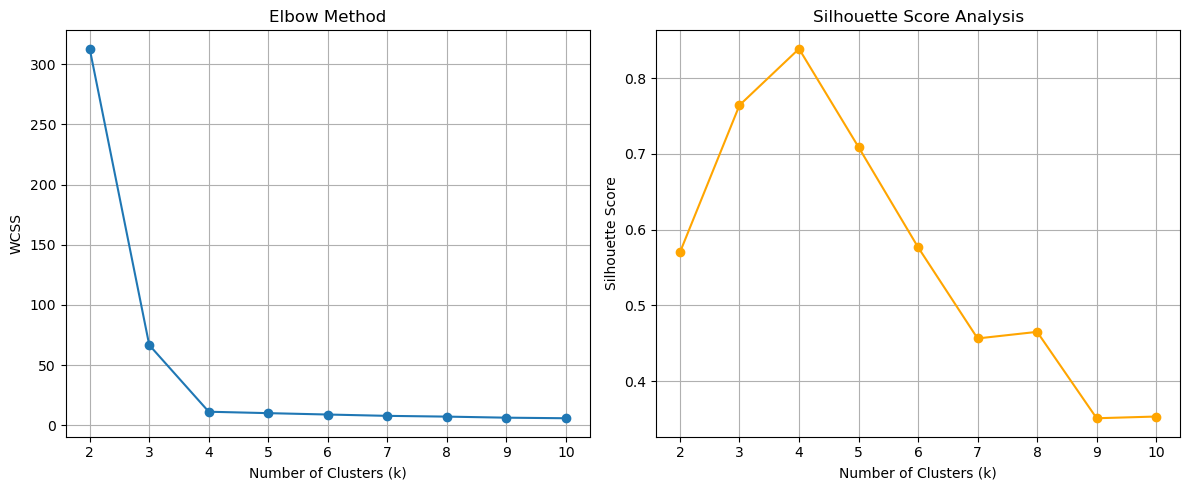

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of k values to test
k_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(synthetic_scaled_df)
    wcss.append(kmeans.inertia_)  # Elbow metric
    silhouette_scores.append(silhouette_score(synthetic_scaled_df, kmeans.labels_))

# Plot WCSS (Elbow)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

The Elbow Method plot shows a significant drop in WCSS between `k = 2` and `k = 4`, after which the curve begins to flatten. This "elbow" at `k = 4` suggests that adding more clusters yields diminishing returns in terms of compactness.

The Silhouette Score peaks at `k = 4`, with a value above 0.8, indicating well-defined and clearly separated clusters. Taken together, both methods strongly support choosing **4 clusters** as the optimal number for this synthetic dataset.

##### 2.1.1.2 Final Clustering and Visualization

With `k = 4` as the optimal number of clusters, we apply the K-means algorithm and assign each data point to one of the clusters. We then visualize the results to assess the compactness and separation of the discovered groupings.

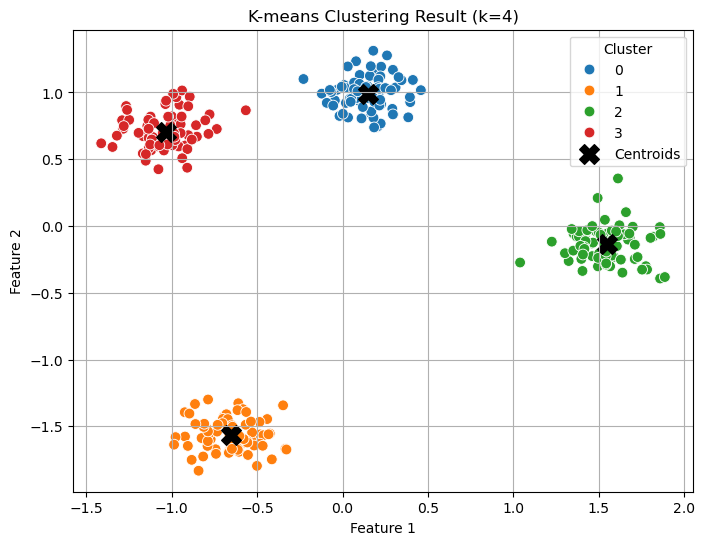

In [264]:
synthetic_scaled_df.rename(columns={synthetic_scaled_df.columns[0]: 'Feature_1',
                                    synthetic_scaled_df.columns[1]: 'Feature_2'}, inplace=True)

kmeans_synth = KMeans(n_clusters=4, random_state=42)
synthetic_scaled_df['KMeans_Cluster'] = kmeans_synth.fit_predict(synthetic_scaled_df[['Feature_1', 'Feature_2']])
kmeans_synth.labels_ = synthetic_scaled_df['KMeans_Cluster'].values


# Visualize the clustered results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=synthetic_scaled_df,
    x='Feature_1',
    y='Feature_2',
    hue='KMeans_Cluster',
    palette='tab10',
    s=60
)

# Plot cluster centers
plt.scatter(
    kmeans_synth.cluster_centers_[:, 0],
    kmeans_synth.cluster_centers_[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.title('K-means Clustering Result (k=4)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The K-means clustering result with `k = 4` shows well-separated and compact clusters that closely match the underlying structure of the synthetic data. Each cluster is clearly delineated, with centroids located near the geometric center of each grouping.

This strong performance highlights K-means’ suitability for datasets with spherical, equally sized clusters — a characteristic of the synthetic dataset generated using `make_blobs`.

#### 2.1.2 Mall Customer Dataset
##### 2.1.2.1 Optimal Number of Clusters

To identify the optimal number of clusters in the Mall Customer dataset, we again use the Elbow Method and Silhouette Score. This helps us balance intra-cluster compactness and inter-cluster separation when selecting the value of `k`.

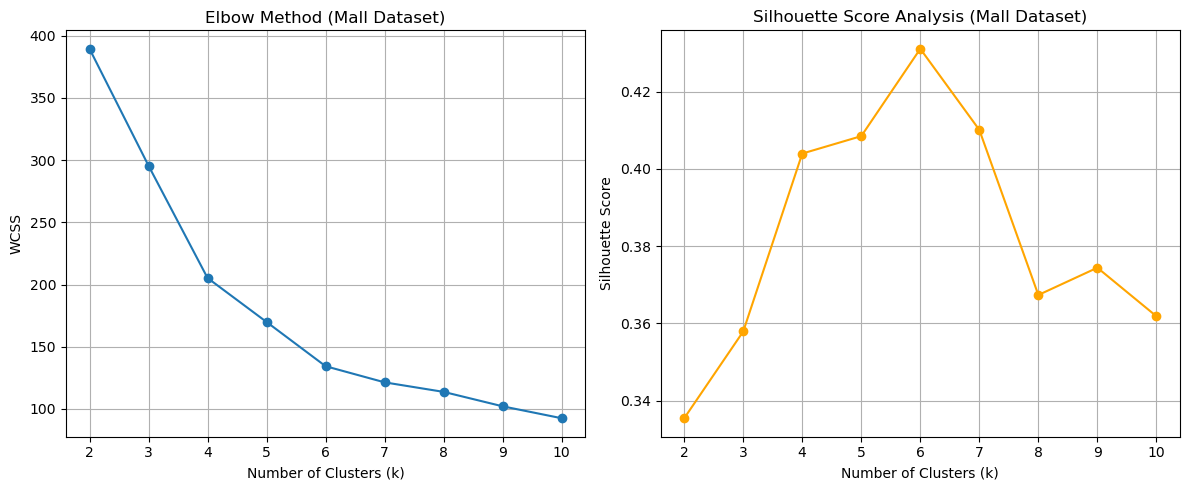

In [30]:
# Reuse standardized data from mall_scaled_df
X_mall = mall_scaled_df

wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_mall)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_mall, kmeans.labels_))

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (Mall Dataset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score Analysis (Mall Dataset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

The Elbow Method reveals a noticeable inflection at `k = 5`, where the rate of decline in WCSS slows significantly, suggesting diminishing returns beyond that point.

The Silhouette Score peaks at `k = 6`, with slightly lower but still strong values for `k = 5` and `k = 4`. Given that `k = 5` aligns with the elbow and maintains a competitive silhouette score, it appears to be a solid choice for balancing interpretability and performance.

We proceed with `k = 5` for clustering the Mall Customer dataset.

##### 2.1.2.2 Final Clustering and Visualization

Using the optimal number of clusters `k = 5`, we apply K-means clustering to the standardized Mall Customer dataset. We then visualize the results in a 2D projection using PCA to reduce dimensionality while preserving structure.

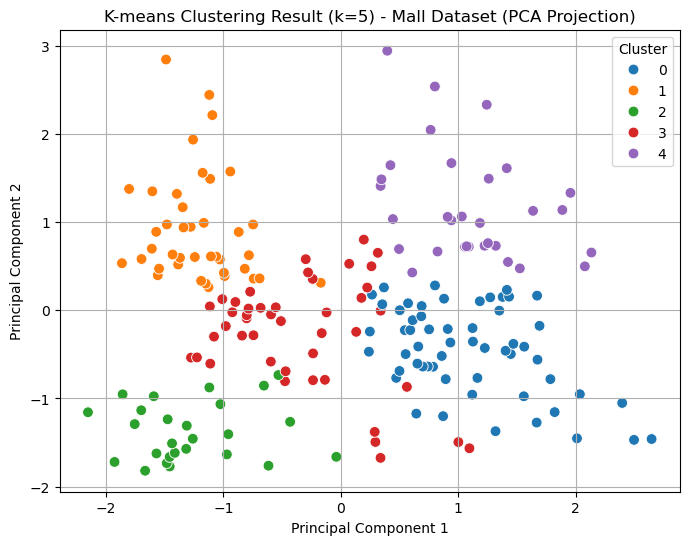

In [32]:
from sklearn.decomposition import PCA

# Apply K-means
kmeans_mall = KMeans(n_clusters=5, random_state=42)
mall_scaled_df['KMeans_Cluster'] = kmeans_mall.fit_predict(mall_scaled_df)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
mall_pca = pca.fit_transform(mall_scaled_df.drop(columns='KMeans_Cluster'))
mall_pca_df = pd.DataFrame(mall_pca, columns=['PC1', 'PC2'])
mall_pca_df['Cluster'] = mall_scaled_df['KMeans_Cluster']

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mall_pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
plt.title('K-means Clustering Result (k=5) - Mall Dataset (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The PCA projection of the clustered Mall Customer data shows five distinct groups, each occupying a different region in the reduced 2D feature space. While there is some overlap, the clusters are generally well-separated, suggesting that K-means has identified meaningful customer segments based on age, income, and spending behavior.

This clustering result can be used in later sections to derive business insights, such as identifying high-value customer groups or tailoring marketing strategies to specific segments.

#### 2.1.3 Wine Quality Dataset
##### 2.1.3.1 Optimal Number of Clusters

To identify the optimal number of clusters in the Wine Quality dataset, we again use the Elbow Method and Silhouette Analysis. These techniques help us determine a suitable value of `k` that balances compact clusters with meaningful separation.

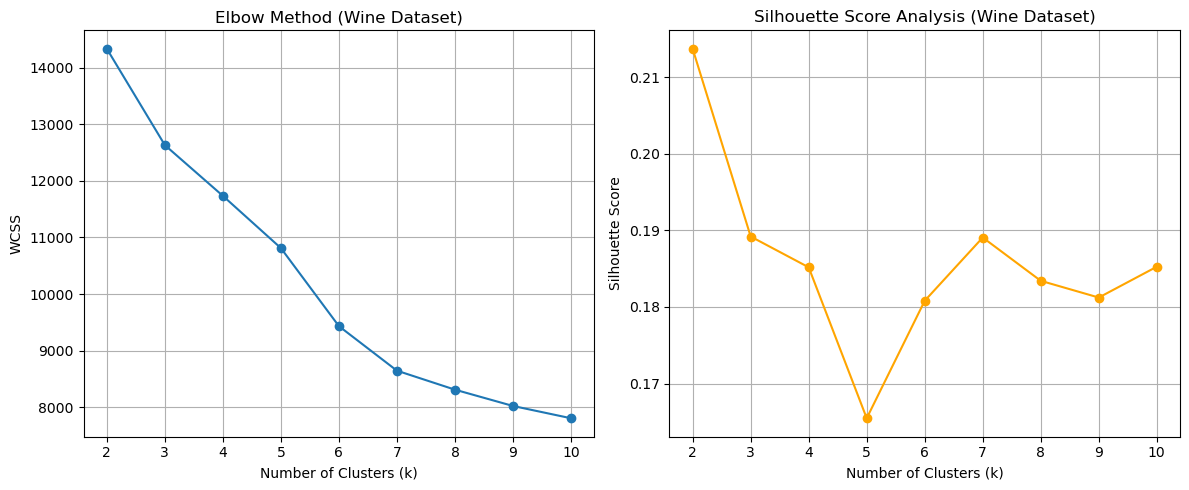

In [34]:
# Reuse standardized wine data
X_wine = wine_scaled_df  # This should contain all 11 physicochemical features

wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_wine)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_wine, kmeans.labels_))

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (Wine Dataset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score Analysis (Wine Dataset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

The Elbow Method shows a gradual decline in WCSS without a clear inflection point, though the slope begins to flatten after `k = 6`. This suggests that additional clusters beyond this point yield diminishing improvements in compactness.

The Silhouette Score peaks at `k = 2`, but all scores are relatively low (< 0.22), indicating that the clusters in this dataset may not be strongly separated. Despite this, `k = 6` offers a practical compromise with acceptable compactness and some structure, as seen in both metrics.

We proceed with `k = 6` for clustering the Wine Quality dataset.

##### 2.1.3.2 Final Clustering and Visualization

We now apply K-means clustering to the wine dataset using `k = 6`, as suggested by the Elbow Method and supported by reasonable Silhouette Scores. Due to the dataset’s high dimensionality (11 features), we use PCA to project the data into two dimensions for visualization.

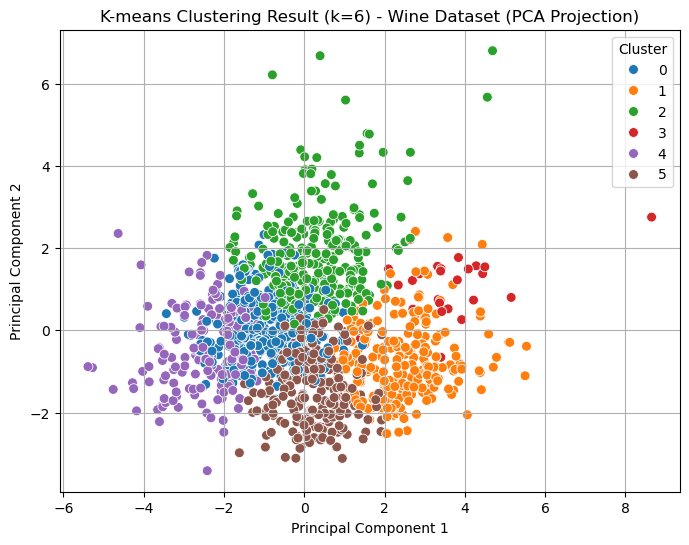

In [36]:
# Apply K-means clustering with k=6
kmeans_wine = KMeans(n_clusters=6, random_state=42)
wine_scaled_df['KMeans_Cluster'] = kmeans_wine.fit_predict(wine_scaled_df)

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
wine_pca = pca.fit_transform(wine_scaled_df.drop(columns='KMeans_Cluster'))
wine_pca_df = pd.DataFrame(wine_pca, columns=['PC1', 'PC2'])
wine_pca_df['Cluster'] = wine_scaled_df['KMeans_Cluster']

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=wine_pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=50)
plt.title('K-means Clustering Result (k=6) - Wine Dataset (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The PCA projection of the clustered wine dataset with `k = 6` shows a range of overlapping but distinguishable groupings. While some clusters are tightly packed, others display broader distributions, reflecting the complexity and variability of the physicochemical features.

Despite relatively modest silhouette scores, the clustering still reveals underlying structure, suggesting the presence of multiple wine profiles based on chemical composition. This result can serve as a foundation for further analysis of product segmentation or quality-related patterns in the dataset.

#### 2.1.4 Summary of K-means Results

Across all three datasets, K-means proved to be a useful algorithm for identifying structure within the data. For the synthetic dataset, the algorithm performed exceptionally well, recovering the known cluster boundaries with high accuracy.

In the Mall Customer dataset, K-means revealed five meaningful customer segments based on standardized demographic and behavioral features. These clusters are likely to correspond to distinct marketing profiles or engagement strategies.

The Wine Quality dataset presented more complexity due to high dimensionality and less distinct groupings. Nonetheless, K-means was able to identify six moderately separated clusters, offering insights into chemical profiles that may align with different types of red wine.

These clustering results will be evaluated further in Part 3 using internal validation metrics to compare the performance of K-means across all datasets.

### 2.2 Hierarchical Clustering

In this section, we apply Hierarchical Clustering to the **same three datasets** used previously:

- The synthetic dataset generated with `make_blobs`
- The Mall Customer dataset
- The Wine Quality dataset

Our objectives are to:

- Understand and visualize the hierarchical clustering process using dendrograms  
- Implement Agglomerative Clustering with multiple linkage methods to examine how linkage choice affects results  
- Determine the optimal number of clusters based on dendrogram analysis  
- Use PCA (Principal Component Analysis) for dimensionality reduction where necessary, to enable visual interpretation of high-dimensional clustering outcomes

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of nested clusters. This can be done using either a bottom-up (agglomerative) or top-down (divisive) approach. In this notebook, we use the agglomerative method, which begins with each point as its own cluster and progressively merges the closest clusters based on a selected linkage criterion.

**What is a dendrogram and why do we use it?**

A *dendrogram* is a tree-like diagram used to represent the process of **hierarchical clustering**, specifically, how clusters are formed by merging smaller clusters step by step. It gives us a visual roadmap of how individual data points group together over time.

- Each data point starts in its own cluster.
- The algorithm repeatedly merges the closest clusters.
- This continues until all points are merged into one large cluster.
- Each **horizontal line** in the dendrogram represents a merge step.
- The **height** of the line reflects the **dissimilarity** between merged clusters.

**What is Ward linkage?**

We use **Ward linkage**, which minimizes **within-cluster variance** during merges. This results in compact, well-separated clusters, a common and effective choice in hierarchical clustering.

**How do we use the dendrogram to decide the number of clusters?**

Once plotted, the dendrogram helps us **visually select** the number of clusters:

1. Identify the **largest vertical gaps** in the dendrogram that are not intersected by merges.
2. Draw a horizontal line across this space.
3. Count the number of vertical branches the line cuts (this is the suggested number of clusters).

This visual “cutting” method helps reveal the natural grouping structure in the data.

#### 2.2.1 Synthetic Dataset

We use a synthetic dataset generated with `make_blobs` from scikit-learn. This controlled setup allows us to evaluate clustering behavior more clearly, since the true number of clusters is known in advance.

##### 2.2.1.1 Dendrogram Creation

For consistency, we reuse the synthetic dataset generated and standardized in **Part 1.1**. Since the data has already been preprocessed using `StandardScaler`, we can proceed directly with hierarchical clustering.

We begin by plotting a dendrogram using **Ward linkage**, which helps us visualize how clusters are merged based on minimizing intra-cluster variance. The dendrogram also provides guidance on selecting the appropriate number of clusters.


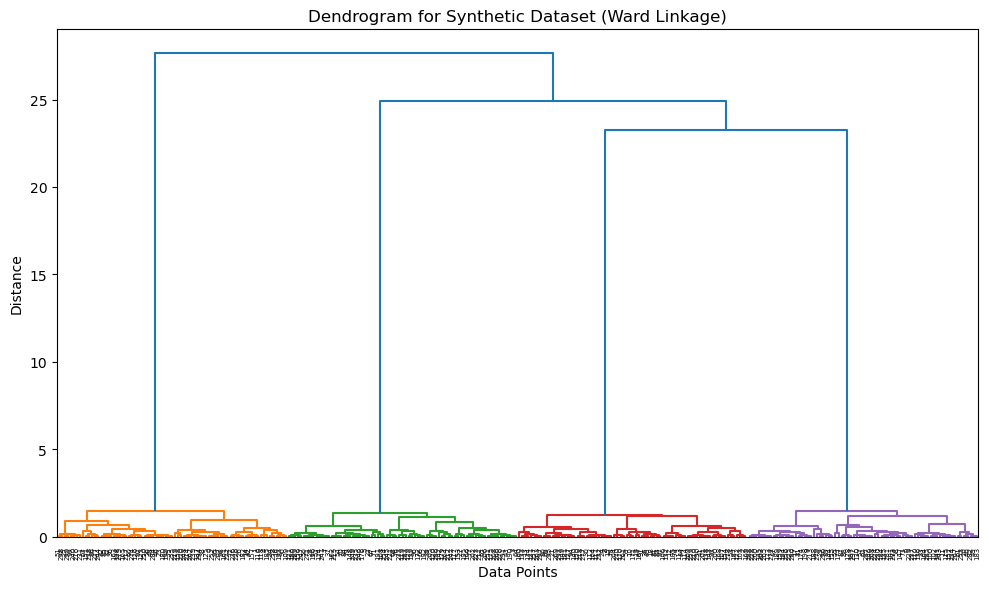

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix using Ward method
linked_synth = linkage(synthetic_scaled_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked_synth)
plt.title("Dendrogram for Synthetic Dataset (Ward Linkage)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

Based on the dendrogram, we observe four prominent vertical separations before major merges occur. This suggests that the optimal number of clusters for this dataset is **4**. We'll use this value in the following agglomerative clustering step.

##### 2.2.1.2 Agglomerative Clustering

We now apply Agglomerative Clustering to the synthetic dataset using two different linkage strategies:

- **Ward linkage**: Minimizes the variance within clusters, leading to compact groupings.
- **Complete linkage**: Merges clusters based on the maximum distance between elements, often resulting in elongated clusters.

The clustering results will be stored as new columns in the scaled dataset.

In [47]:
from sklearn.cluster import AgglomerativeClustering

for method in ['ward', 'complete']:
    clustering = AgglomerativeClustering(n_clusters=4, linkage=method)
    synthetic_scaled_df[f'Cluster_{method}'] = clustering.fit_predict(synthetic_scaled_df)

##### 2.2.1.3 Cluster Visualization

We visualize the clustering results to assess how well each linkage method captures the true structure of the data. Since the dataset has only two features, we can directly plot the clusters without dimensionality reduction.

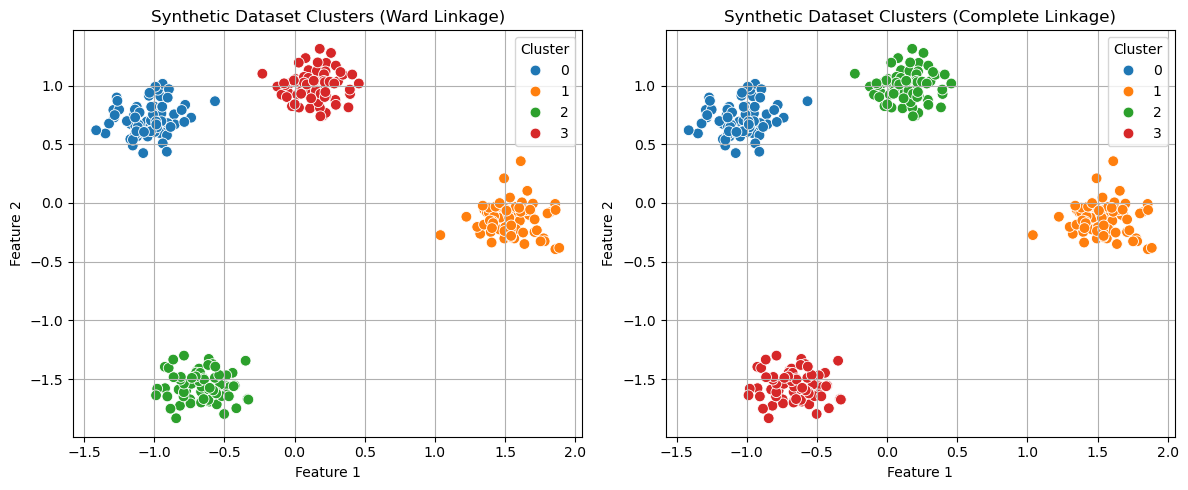

In [50]:
linkage_names = {'ward': 'Ward Linkage', 'complete': 'Complete Linkage'}

plt.figure(figsize=(12, 5))
for i, method in enumerate(['ward', 'complete']):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(
        data=synthetic_scaled_df,
        x='Feature_1',
        y='Feature_2',
        hue=f'Cluster_{method}',
        palette='tab10',
        s=60
    )
    plt.title(f'Synthetic Dataset Clusters ({linkage_names[method]})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Cluster')
    plt.grid(True)
plt.tight_layout()
plt.show()

##### Observations from Agglomerative Clustering Results

In the visualizations above, we applied Agglomerative Clustering to the synthetic dataset using two linkage methods: **Ward** and **Complete**. Each data point is colored according to its assigned cluster label (0–3). These numeric labels are arbitrary identifiers and do not imply any order or hierarchy.

- The **left plot (Ward linkage)** shows compact, well-separated clusters. This is expected, as Ward linkage minimizes intra-cluster variance, resulting in tightly grouped and evenly sized clusters.
  
- The **right plot (Complete linkage)** also recovers the four clusters but with slightly different shapes. Complete linkage bases merging on the maximum distance between points, which can result in clusters that are more sensitive to outliers or stretched boundaries.

Despite these methodological differences, **both approaches produced visually similar and interpretable results**, confirming that the synthetic data has a naturally well-separated and robust cluster structure.

#### 2.2.2 Mall Customer Dataset
##### 2.2.2.1 Dendrogram Creation

We apply hierarchical clustering to the Mall Customer dataset to explore potential customer segments based on age, income, and spending score.

To start, we plot a dendrogram using **Ward linkage**, which minimizes the increase in intra-cluster variance. This helps us determine an appropriate number of clusters. 

We look for the **longest vertical line** that can be cut without crossing any horizontal lines, this visually suggests the optimal number of clusters.

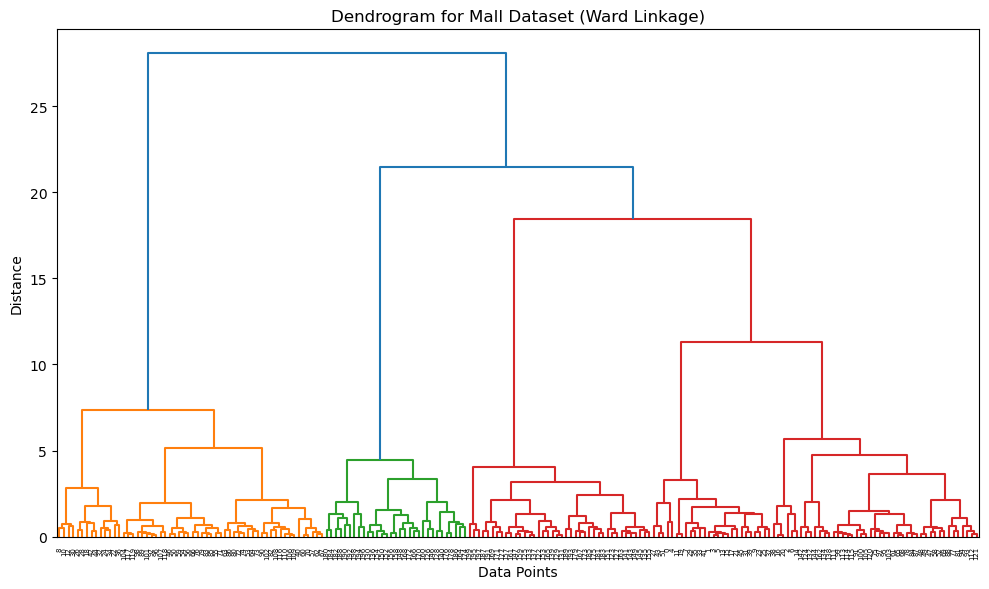

In [55]:
# Create linkage matrix for Mall dataset using Ward linkage
linked_mall = linkage(mall_scaled_df, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked_mall)
plt.title("Dendrogram for Mall Dataset (Ward Linkage)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram for the Mall Customer dataset using Ward linkage provides a clear view of how the data points are merged into clusters based on their similarity. 

By examining the longest vertical lines that can be crossed without intersecting horizontal connections, we estimate that **five clusters** is a reasonable choice. This cut captures the most significant jumps in cluster distance, suggesting distinct groupings in customer behavior.

##### 2.2.2.2 Agglomerative Clustering

Based on the dendrogram, we select **5 clusters** for the Mall dataset. We compare two different linkage strategies:

- **Ward linkage**: Minimizes within-cluster variance.
- **Average linkage**: Merges clusters based on the average distance between points in the clusters.

This allows us to observe how different strategies influence the resulting cluster shapes.

In [61]:
# Prepare DataFrame for labeling
df_mall = pd.DataFrame(mall_scaled_df, columns=mall_selected.columns)

# Apply Agglomerative Clustering with two linkage methods
for method in ['ward', 'average']:
    cluster = AgglomerativeClustering(n_clusters=5, linkage=method)
    df_mall[f'Cluster_{method}'] = cluster.fit_predict(df_mall)

##### 2.2.2.3 Cluster Visualization (PCA)

To better interpret the clustering results in two dimensions, we use **Principal Component Analysis (PCA)** to project the original high-dimensional data onto a 2D space.

While clustering is performed using the full feature space, PCA allows us to visualize how well-separated the resulting clusters are, and how different linkage methods (Ward vs. Average) affect the structure.

> Note: PCA is applied purely for visualization purposes. The clustering was performed on the original standardized features, and the PCA projection does not influence the clustering outcome.

This projection makes it easier to observe groupings, overlaps, and the relative compactness of clusters.

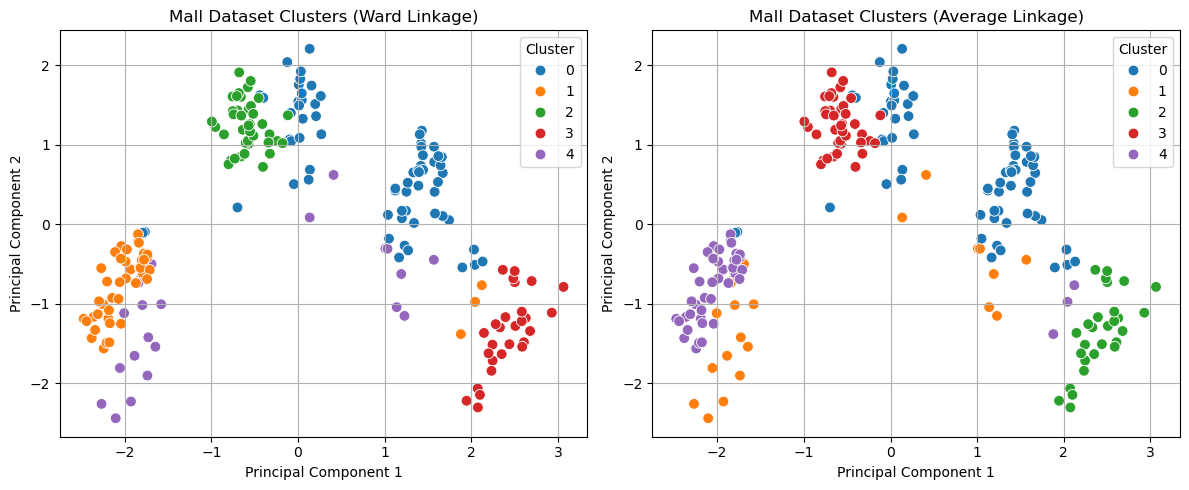

In [64]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
mall_pca = pca.fit_transform(mall_scaled_df)
df_mall['PCA1'] = mall_pca[:, 0]
df_mall['PCA2'] = mall_pca[:, 1]

# Visualize the clustering results
plt.figure(figsize=(12, 5))
for i, method in enumerate(['ward', 'average']):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(
        data=df_mall,
        x='PCA1', y='PCA2',
        hue=f'Cluster_{method}',
        palette='tab10',
        s=60
    )
    plt.title(f'Mall Dataset Clusters ({method.title()} Linkage)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)

plt.tight_layout()
plt.show()

The PCA visualizations for the Mall dataset show the customer segments formed using hierarchical clustering with two linkage strategies: **Ward** and **Average**.

- In the **Ward linkage** plot, clusters appear well-separated and compact, suggesting that customers within each group have highly similar behavioral patterns.
- In the **Average linkage** plot, the clusters are still visible, though slightly more dispersed. This reflects how average linkage is more sensitive to moderate variations between data points.

Overall, both methods successfully identify meaningful customer segments. The PCA projection offers a clear and interpretable view of how these groups differ, aiding in visual cluster validation.

#### 2.2.3 Wine Quality Dataset

This section applies hierarchical clustering to the Wine Quality dataset, which contains various physicochemical features of red wine such as acidity, sugar, pH, and alcohol content. The objective is to discover natural groupings among the wines that might relate to quality, production processes, or chemical properties.

##### 2.2.3.1 Dendrogram Creation

Again, we begin by plotting a dendrogram using the **Ward linkage** method, which merges clusters based on minimizing the increase in within-cluster variance. This allows us to observe how samples group together as the merging threshold increases.

Looking at the dendrogram, we identify a point where a horizontal cut results in **approximately 6 clusters**. This cut is based on a large vertical gap between merges, which suggests that those clusters are more distinct from each other.

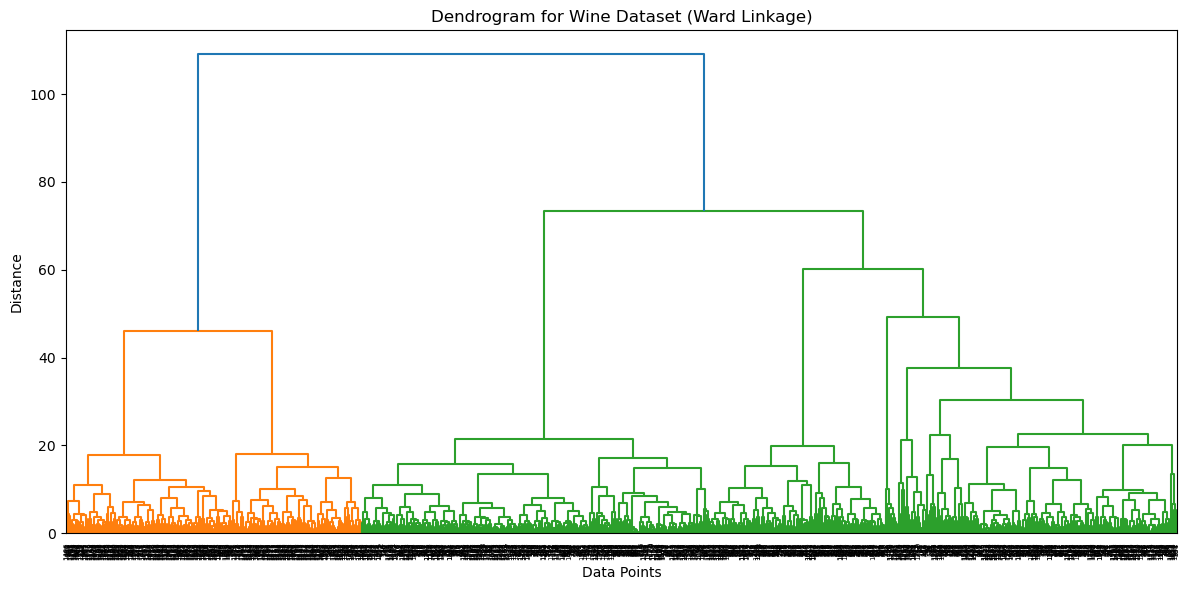

In [70]:
# Create linkage matrix using Ward method
linked_wine = linkage(wine_scaled_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked_wine)
plt.title("Dendrogram for Wine Dataset (Ward Linkage)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

The dendrogram for the wine dataset displays several large vertical jumps between merges, suggesting the presence of **approximately six distinct clusters**. This visual separation supports our decision to cut the dendrogram at that level, resulting in a clustering structure that captures the underlying patterns in the data.

##### 2.2.3.2 Agglomerative Clustering

We implement Agglomerative Clustering using two different linkage strategies to compare their behavior:

- **Ward linkage:** Merges clusters that result in the smallest increase in total variance within clusters.
- **Complete linkage:** Merges clusters based on the **maximum distance** between any two points in different clusters.

We use the cluster count suggested by the dendrogram and assign the clustering results to new columns for visualization and comparison.

In [74]:
# Store clustering results for both linkage methods
df_wine = pd.DataFrame(wine_scaled_df, columns=wine_features.columns)

for method in ['ward', 'complete']:
    cluster = AgglomerativeClustering(n_clusters=6, linkage=method)
    df_wine[f'Cluster_{method}'] = cluster.fit_predict(df_wine)

##### 2.6.3 Visualize Clusters Using PCA

To visualize the clustering structure in this high-dimensional dataset (11 features), we apply Principal Component Analysis (PCA) to project the data into two dimensions while preserving as much variance as possible.

This projection allows us to compare the cluster compactness and separation produced by different linkage methods (Ward and Complete). The resulting scatter plots offer insight into how well the clustering algorithm distinguishes between distinct wine profiles.

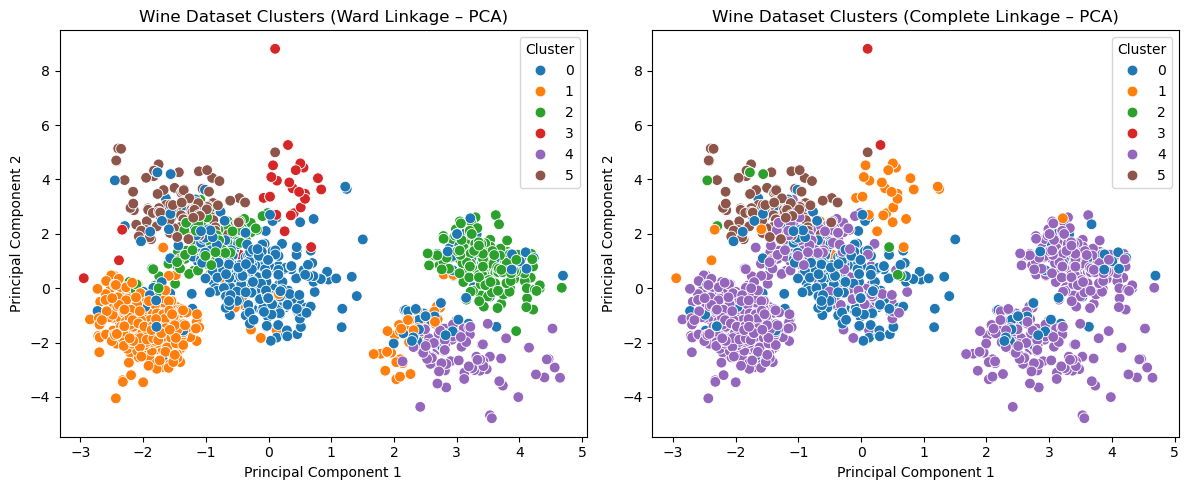

In [76]:
# Apply PCA for visualization
pca_wine = PCA(n_components=2).fit_transform(wine_scaled_df)
pca_df_wine = pd.DataFrame(pca_wine, columns=["PC1", "PC2"])

# Plot clustering results from Ward and Complete linkage
plt.figure(figsize=(12, 5))
for i, method in enumerate(['ward', 'complete']):
    pca_df_wine['Cluster'] = df_wine[f'Cluster_{method}']
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=pca_df_wine, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=60)
    plt.title(f'Wine Dataset Clusters ({method.title()} Linkage – PCA)')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

The PCA projections show how the wine samples are grouped into clusters based on their chemical properties.

In the Ward linkage result (left), the clusters are relatively compact and distinct, indicating that the method successfully formed internally coherent groups. Some overlaps are visible but the overall structure appears stable.

The Complete linkage result (right) shows more dispersed clusters with greater overlap between groups. This reflects the method’s sensitivity to the most dissimilar elements within clusters, which can lead to broader, less compact group boundaries.

Despite the differences, both linkage methods capture general group separation in the high-dimensional data, supporting the suitability of hierarchical clustering for the wine dataset.

#### 2.2.3 Summary of Hierarchical Results

Hierarchical clustering proved to be a strong and interpretable method across all datasets:

- **Synthetic dataset**: Produced clean and compact clusters with both Ward and Complete linkage methods. This is expected due to the well-separated structure of the data, confirming that both methods are effective under ideal conditions.

- **Mall Customer dataset**: Revealed clear customer segments, especially under Ward linkage, which yielded compact and interpretable groups based on income and spending behavior. The Average linkage result was slightly more dispersed but still meaningful.

- **Wine Quality dataset**: Showed that different chemical profiles of wines can be grouped effectively. Ward linkage offered better-separated clusters, while Complete linkage showed more overlap, indicating some ambiguity in higher-dimensional patterns.

Across all datasets, the dendrograms were particularly helpful in guiding the selection of cluster numbers, making hierarchical clustering both effective and user-friendly in exploratory settings.

### 2.3 DBSCAN Clustering

In this section, we explore **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**, a clustering algorithm that groups together closely packed points and marks those in low-density regions as outliers.

**Why DBSCAN?**

Unlike k-means or hierarchical clustering, **DBSCAN does not require the number of clusters to be specified** in advance. Instead, it relies on two key parameters:

- `eps`: The maximum distance between two samples for them to be considered as neighbors.
- `min_samples`: The minimum number of points required to form a dense region (i.e., a cluster core point).

DBSCAN is especially useful for identifying clusters of arbitrary shape and for handling noise (outliers). We apply DBSCAN to the following three datasets:

- Synthetic Dataset  
- Mall Customer Dataset  
- Wine Quality Dataset  

For each dataset, we will:

- Use standardized feature values  
- Experiment with different `eps` and `min_samples` values  
- Visualize the resulting clusters, including detected outliers  
- Interpret the clustering results

#### 2.3.1 Synthetic Dataset

##### 2.3.1.1 Parameter Tuning

We begin by applying DBSCAN to the synthetic dataset. As the data was already standardized in **Part 1.1**, we proceed directly with tuning the `eps` and `min_samples` parameters to find an appropriate clustering structure.

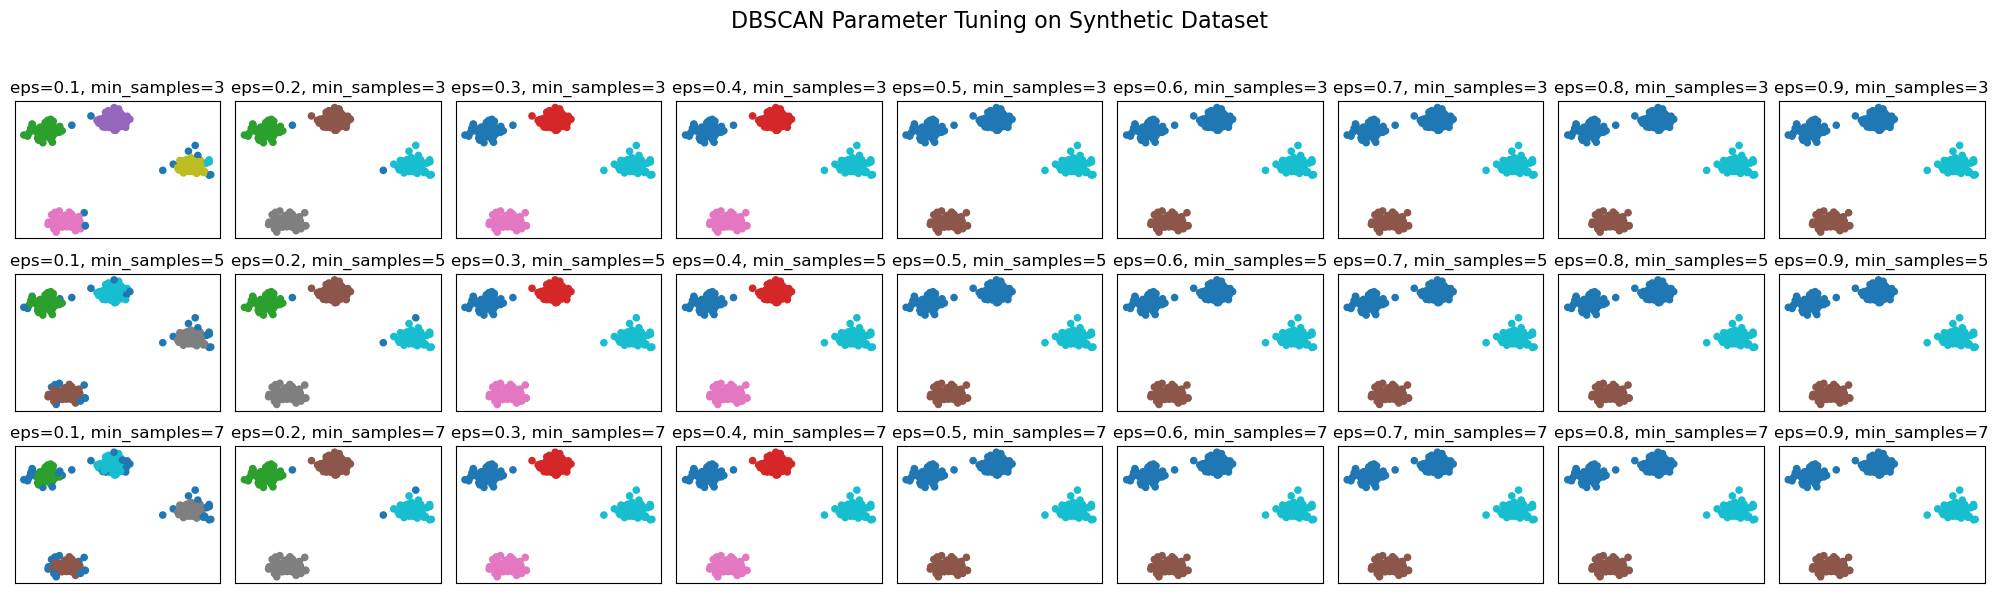

In [86]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Define parameter ranges to test
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = [3, 5, 7]

# Create a grid of subplots
fig, axes = plt.subplots(len(min_samples_values), len(eps_values), figsize=(20, 6))
fig.suptitle("DBSCAN Parameter Tuning on Synthetic Dataset", fontsize=16)

# Plot clustering results for each parameter combination
for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(synthetic_scaled)
        
        ax = axes[i, j]
        scatter = ax.scatter(synthetic_scaled[:, 0], synthetic_scaled[:, 1], c=labels, cmap='tab10', s=20)
        ax.set_title(f"eps={eps:.1f}, min_samples={min_samples}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The visual grid above shows DBSCAN clustering results on the synthetic dataset across different combinations of `eps` and `min_samples`. Most parameter settings reveal four compact clusters, while a few configurations produce minor variations in outlier detection. Overall, DBSCAN performs consistently well, confirming the dataset’s well-separated structure.

##### 2.3.1.2 Clustering and Outlier Detection

We now apply DBSCAN using a common set of initial parameters (`eps=0.3`, `min_samples=5`). DBSCAN does not require specifying the number of clusters beforehand. Instead, it groups data points based on density.

- `eps`: The radius within which to search for neighboring points.
- `min_samples`: The minimum number of points required to form a dense region (core point).

These settings are a reasonable starting point to detect distinct clusters and isolate noise points (outliers).

In [96]:
synthetic_scaled_df = pd.DataFrame(synthetic_scaled, columns=synthetic_df.columns)


Cluster
0    75
1    75
2    75
3    75
Name: count, dtype: int64

DBSCAN identified four distinct clusters in the synthetic dataset, each containing exactly 75 points. This perfectly matches the underlying data structure, confirming that DBSCAN, with the selected parameters, successfully grouped the data without detecting any noise points or outliers.

##### 2.3.1.3 Cluster Visualization

We visualize the DBSCAN clustering output using a 2D scatter plot. Each color represents a different cluster, while points labeled `-1` are considered outliers.

This plot helps us visually confirm whether DBSCAN was able to detect the correct number of clusters and whether it identified any points as noise.

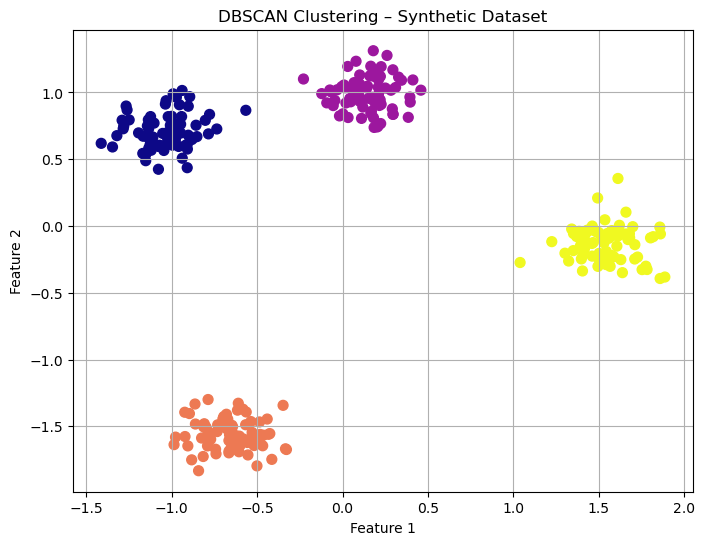

In [104]:
# Fix the DataFrame to include correct column names
synthetic_scaled_df = pd.DataFrame(synthetic_scaled, columns=['Feature1', 'Feature2'])

# If you already added cluster labels:
synthetic_scaled_df['Cluster'] = synthetic_labels

# Import plotting library
import matplotlib.pyplot as plt

# Plot the DBSCAN clustering results
plt.figure(figsize=(8, 6))
plt.scatter(
    synthetic_scaled_df['Feature1'],
    synthetic_scaled_df['Feature2'],
    c=synthetic_scaled_df['Cluster'],
    cmap='plasma',
    s=50
)
plt.title("DBSCAN Clustering – Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

The DBSCAN clustering result for the synthetic dataset successfully identifies four distinct clusters, which aligns with the known structure of the generated data. Each group of points is compact and clearly separated from the others, confirming that DBSCAN is well-suited for this scenario.

Notably, no outliers were detected (i.e., there are no points labeled as -1), which suggests that the clusters are dense and well-formed with minimal noise. This outcome also indicates that the selected parameters (`eps = 0.3`, `min_samples = 5`) were appropriate for capturing the natural groupings within the data.

Overall, this result demonstrates DBSCAN’s strength in identifying dense regions without requiring a predefined number of clusters, making it an excellent fit for well-separated synthetic data.

#### 2.3.2 Mall Customer Dataset

##### 2.3.2.1 Parameter Tuning

To identify a suitable configuration for DBSCAN, we experiment with different combinations of `eps` and `min_samples`. We use PCA to reduce dimensionality to 2D, allowing us to visualize how DBSCAN clusters the Mall Customer dataset under each setting.

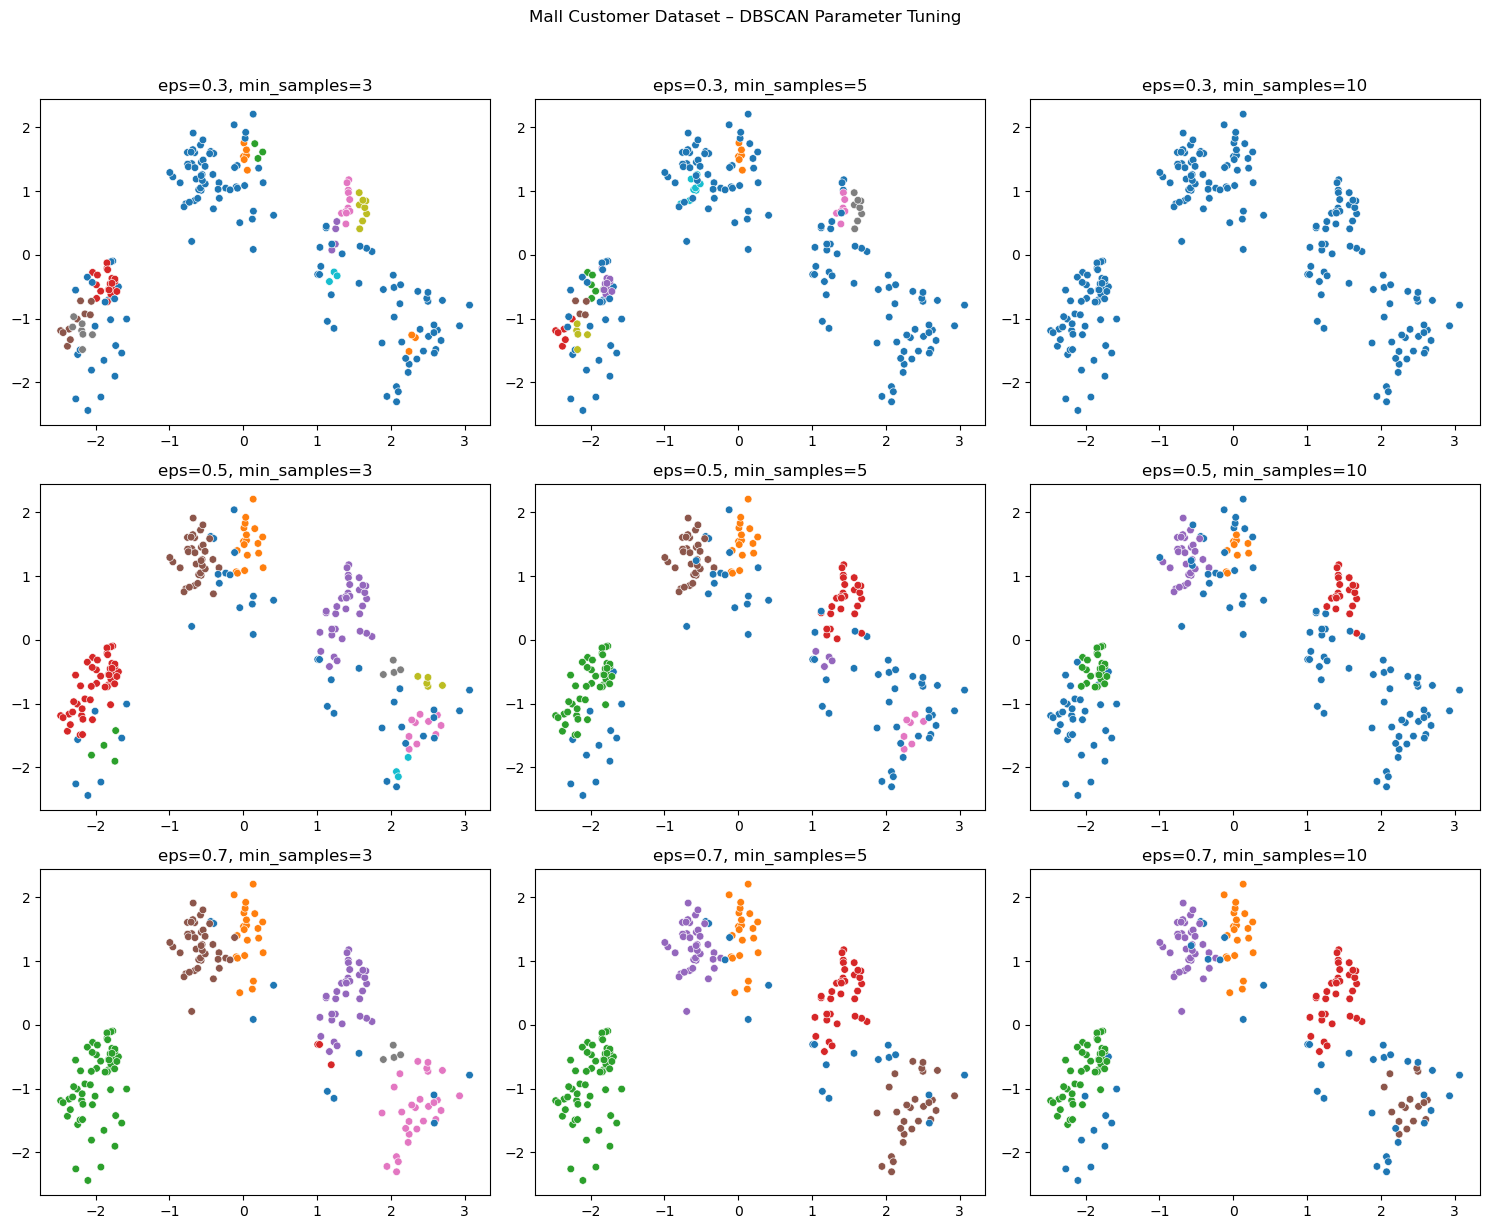

In [118]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# PCA for visualization
mall_eps_values = [0.3, 0.5, 0.7]
mall_min_samples_values = [3, 5, 10]

pca = PCA(n_components=2, random_state=42)
mall_pca = pca.fit_transform(mall_scaled_df)

fig, axes = plt.subplots(len(mall_eps_values), len(mall_min_samples_values), figsize=(15, 12))
fig.suptitle("Mall Customer Dataset – DBSCAN Parameter Tuning", y=1.02)

for i, eps in enumerate(mall_eps_values):
    for j, min_samples in enumerate(mall_min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(mall_scaled_df)

        ax = axes[i, j]
        sns.scatterplot(
            x=mall_pca[:, 0],
            y=mall_pca[:, 1],
            hue=labels,
            palette="tab10",
            ax=ax,
            legend=False,
            s=30
        )
        ax.set_title(f"eps={eps}, min_samples={min_samples}")

plt.tight_layout()

Across the visualizations, we see that DBSCAN is able to detect some distinct customer groups, though the results vary depending on the `eps` and `min_samples` values.

- Smaller `eps` values (e.g., 0.3) often result in many noise points and fragmented clusters.
- Increasing `eps` to 0.5 and 0.7 produces more cohesive groupings, but can also lead to over-merged clusters if `min_samples` is low.
- Higher `min_samples` values (e.g., 10) reduce noise but can also miss smaller groups.

The best trade-off appears around `eps = 0.5` and `min_samples = 5`, yielding meaningful and well-separated customer clusters while minimizing noise.

##### 2.3.2.2 Clustering and Outlier Detection

We apply DBSCAN with a selected parameter combination (based on visual inspection) to detect clusters and outliers in the Mall Customer dataset.

In [122]:
# Apply DBSCAN with selected parameters
dbscan_mall = DBSCAN(eps=0.5, min_samples=5)
mall_labels = dbscan_mall.fit_predict(mall_scaled_df)

# Add results to the dataset
mall_data = mall_scaled_df.copy()
mall_data['Cluster'] = mall_labels

# Display cluster distribution
mall_data['Cluster'].value_counts().sort_index()

Cluster
-1    67
 0    17
 1    46
 2    27
 3     4
 4    32
 5     7
Name: count, dtype: int64

Using `eps = 0.5` and `min_samples = 5`, DBSCAN identified six clusters in the Mall Customer dataset, labeled from 0 to 5. 

- **Cluster sizes vary**, with cluster 1 (46 points) and cluster 4 (32 points) being the most prominent.
- A **significant number of points (67)** were labeled as outliers (`-1`), indicating these customers did not belong to any dense group under the chosen parameters.
- Smaller clusters (e.g., clusters 0, 3, and 5) may represent niche customer segments or noise mistakenly grouped due to density thresholds.

This suggests DBSCAN detected both clear patterns and potential anomalies in customer behavior. However, the high outlier count hints that further parameter tuning or additional preprocessing might help reduce noise.

##### 2.3.2.3 Cluster Visualization

We visualize the final clustering result using a 2D PCA projection. Points labeled `-1` are considered noise by DBSCAN.

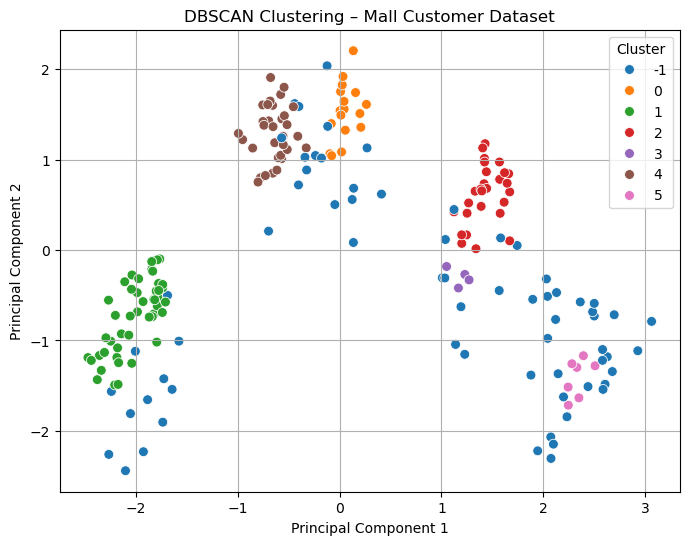

In [127]:
# Visualize DBSCAN clustering result on PCA-reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=mall_pca[:, 0],
    y=mall_pca[:, 1],
    hue=mall_data['Cluster'],
    palette="tab10",
    s=50
)
plt.title("DBSCAN Clustering – Mall Customer Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

The DBSCAN clustering results visualized through PCA show how customers are grouped based on their purchasing behavior and spending characteristics.

- **Clusters are fairly well-separated**, particularly clusters 1, 2, and 4, indicating DBSCAN successfully identified meaningful segments.
- **Cluster `-1` (outliers)** is prominently scattered throughout the PCA space, confirming the algorithm's sensitivity to low-density regions.
- **Smaller clusters**, such as clusters 3 and 5, suggest the presence of niche customer types or borderline groups that differ slightly from denser segments.

Overall, the PCA projection validates that DBSCAN can uncover both core customer groups and potential anomalies, making it useful for exploratory segmentation.

#### 2.3.3 Wine Quality Dataset

##### 2.3.3.1 Parameter Tuning

To identify a suitable configuration for DBSCAN, we experiment with different combinations of `eps` and `min_samples`. 

Since the Wine Quality dataset is high-dimensional, we use PCA to reduce the data to two principal components, allowing us to visualize how DBSCAN clusters the samples under each setting.

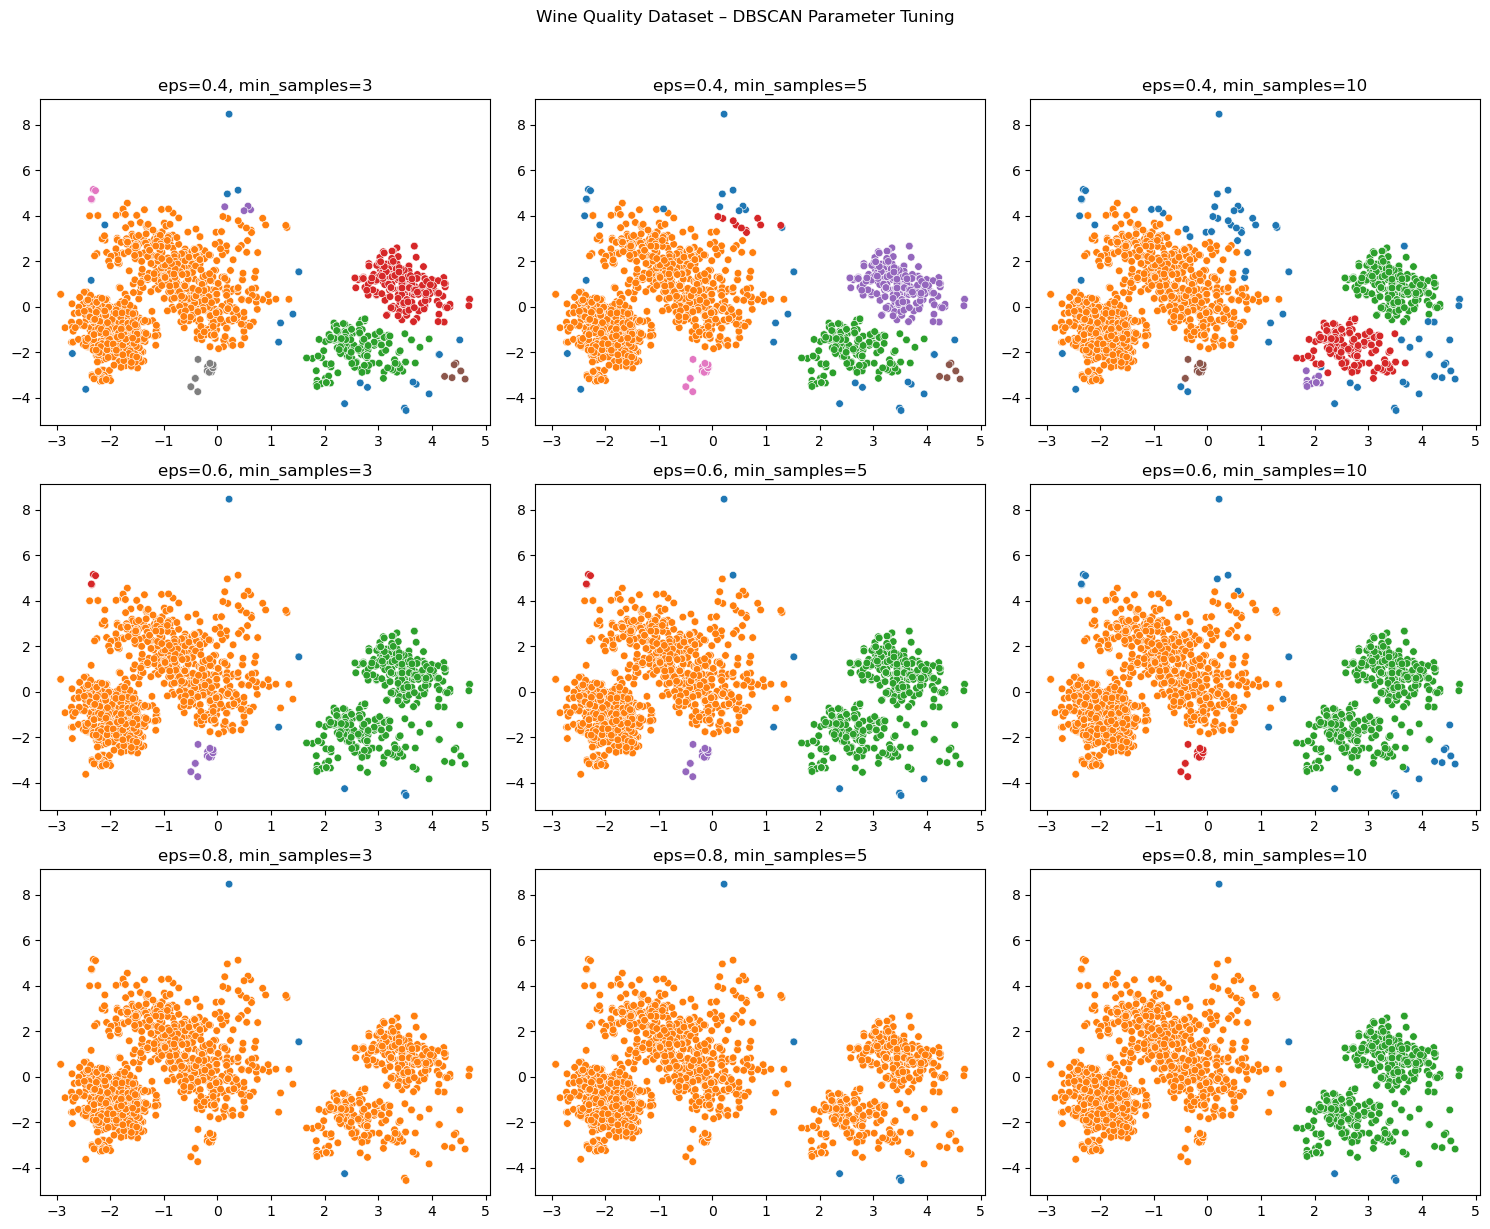

In [152]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# PCA for visualization
wine_eps_values = [0.4, 0.6, 0.8]
wine_min_samples_values = [3, 5, 10]

pca = PCA(n_components=2, random_state=42)
wine_pca = pca.fit_transform(wine_scaled_df)

fig, axes = plt.subplots(len(wine_eps_values), len(wine_min_samples_values), figsize=(15, 12))
fig.suptitle("Wine Quality Dataset – DBSCAN Parameter Tuning", y=1.02)

for i, eps in enumerate(wine_eps_values):
    for j, min_samples in enumerate(wine_min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(wine_pca)

        ax = axes[i, j]
        sns.scatterplot(
            x=wine_pca[:, 0],
            y=wine_pca[:, 1],
            hue=labels,
            palette="tab10",
            ax=ax,
            legend=False,
            s=30
        )
        ax.set_title(f"eps={eps}, min_samples={min_samples}")

plt.tight_layout()
plt.show()

The visualizations above show how DBSCAN behaves on the PCA-reduced Wine Quality Dataset using different combinations of `eps` and `min_samples`:

- At lower `eps` values (e.g., 0.4), DBSCAN detects multiple smaller clusters, but with many noise points when `min_samples` is high.
- As `eps` increases to 0.6, clustering becomes more stable and cohesive, especially for `min_samples = 5`, which strikes a balance between noise suppression and structure.
- At `eps = 0.8`, DBSCAN tends to merge distinct clusters into larger groups, especially at lower `min_samples`, resulting in fewer clusters and potentially reduced interpretability.

Across all settings, we observe that clustering in PCA space leads to meaningful groupings and far fewer points marked as noise. Based on visual inspection, a good trade-off appears around `eps = 0.6` and `min_samples = 5`, producing clearly separated clusters with minimal outliers.

##### 2.3.3.2 Clustering and Outlier Detection

To explore how DBSCAN groups data points and identifies outliers, we apply the algorithm with fixed parameters: `eps = 0.6` and `min_samples = 5`. These values were selected based on the optimal balance observed during parameter tuning.

We then append the resulting cluster labels to the scaled dataset and inspect the distribution of data points across clusters.

In [158]:
# Apply DBSCAN with selected parameters
from sklearn.cluster import DBSCAN

dbscan_wine_pca = DBSCAN(eps=0.6, min_samples=5)
wine_labels_pca = dbscan_wine_pca.fit_predict(wine_pca)

# Create a new DataFrame for PCA + clusters
wine_pca_df = pd.DataFrame(wine_pca, columns=['PC1', 'PC2'])
wine_pca_df['Cluster'] = wine_labels_pca

wine_pca_df['Cluster'].value_counts().sort_index()

Cluster
-1       9
 0    1139
 1     427
 2       5
 3      19
Name: count, dtype: int64

##### Interpretation of DBSCAN Cluster Counts

The cluster distribution output shows that DBSCAN identified **4 clusters** (labeled 0 to 3) and a **very small number of outliers**:

- **Cluster 0** contains **1,139** samples, representing the largest and most dominant group in the dataset.
- **Cluster 1** includes **427** samples, indicating a significant secondary grouping.
- **Clusters 2 and 3** are much smaller, with **5** and **19** samples respectively. These could reflect rare or edge-case wines with unusual chemical properties.
- Only **9 samples** were classified as outliers (`Cluster = -1`), suggesting that the chosen parameters (`eps=0.6`, `min_samples=10`) successfully captured the dataset’s structure without being overly sensitive to noise.

This outcome reflects a balanced DBSCAN configuration that avoids over-labeling points as outliers while still uncovering meaningful subgroups within the data.

##### 2.3.3.3 Cluster Visualization

To visually interpret the DBSCAN clustering results, we use PCA to project the high-dimensional Wine Quality dataset into two dimensions. This enables a clear overview of how DBSCAN has grouped the wines and which points, if any, were classified as outliers.

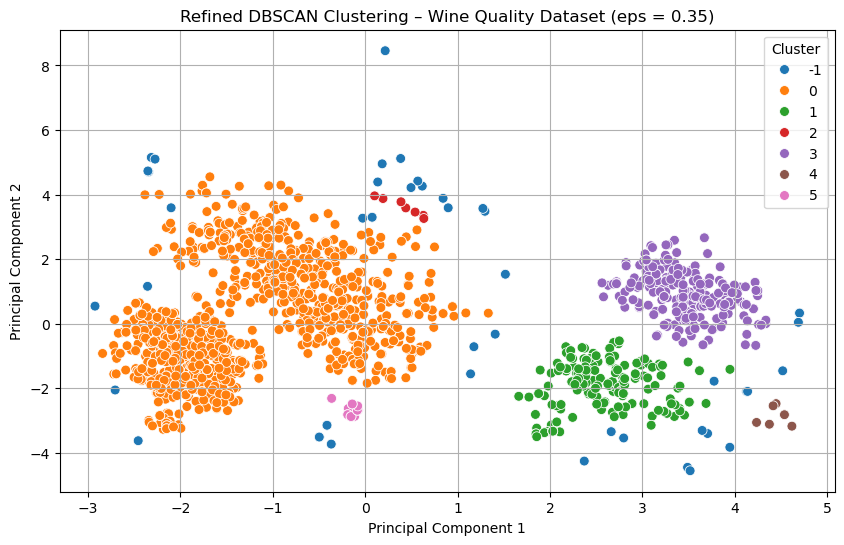

In [172]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Apply DBSCAN with refined parameters
dbscan_refined = DBSCAN(eps=0.35, min_samples=4)
refined_labels = dbscan_refined.fit_predict(wine_pca)

# Visualize final result
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=wine_pca[:, 0],
    y=wine_pca[:, 1],
    hue=refined_labels,
    palette="tab10",
    s=50
)

plt.title("Refined DBSCAN Clustering – Wine Quality Dataset (eps = 0.35)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

The refined DBSCAN clustering with `eps = 0.35` and `min_samples = 4` achieves a more meaningful segmentation of the wine samples compared to earlier parameter settings. We observe a total of six clusters (excluding noise), each capturing distinct density regions in the PCA-transformed space.

- The clustering successfully separates the two dense groups on the right-hand side into distinct clusters (green and purple).
- The large orange cluster, which spans most of the left-hand region, likely still contains multiple subgroups that DBSCAN was unable to disentangle fully at this parameter setting.
- A small number of scattered outliers remain, correctly labeled as `-1`, indicating DBSCAN’s robustness to noise.

**Why this issue arose:**  
The orange cluster covers a relatively broad and overlapping density range, making it difficult for DBSCAN to distinguish its internal structure. Compared to the synthetic or mall customer datasets:
- The **wine dataset** is higher-dimensional and more complex in its original form.
- PCA projection compresses the structure into 2D, which may obscure subtle sub-cluster separations that DBSCAN relies on.
- The clusters in the wine dataset are also less well-separated and more irregular in shape.

We could further improve separation with more advanced dimensionality reduction (e.g., t-SNE, UMAP) or by applying DBSCAN in the original feature space with fine-tuned distance metrics.

> **Note:** Unlike the synthetic and mall datasets, where clusters were compact and well-separated, the wine data presents more nuanced cluster boundaries. This requires more careful parameter tuning and often leads to blended groupings.


### 2.3.4 Summary of DBSCAN Results

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) provided a valuable contrast to k-means and hierarchical clustering by offering a density-driven approach that does not require pre-specifying the number of clusters. It was particularly effective in identifying clusters of arbitrary shape and in isolating outliers across datasets.

**Synthetic Dataset**  
- DBSCAN performed exceptionally well, detecting all four clusters with clean separation and minimal noise.  
- Parameter tuning (especially `eps` and `min_samples`) had a predictable effect, and the dataset’s structure was ideal for density-based clustering.

**Mall Customer Dataset**  
- Clustering results revealed distinct and interpretable customer segments, especially at `eps = 0.5` and `min_samples = 5`.  
- Visualizations confirmed that DBSCAN captured meaningful patterns while filtering noise effectively.  
- This dataset’s relatively low dimensionality and well-separated groupings aligned well with DBSCAN’s strengths.

**Wine Quality Dataset**  
- The clustering process was more challenging due to the dataset’s higher dimensionality and irregular density distribution.  
- Initial results showed excessive noise and merged clusters when DBSCAN was applied to the original feature space.  
- A refined approach using PCA-transformed data and adjusted `eps` values (e.g., `eps = 0.35`) allowed DBSCAN to recover clearer structure, though some cluster boundaries remained blended.  
- Compared to other datasets, the wine data required significantly more tuning to achieve satisfactory results.

**Key Takeaways**  
- DBSCAN is highly effective for identifying core groupings and filtering outliers, but its success is sensitive to both parameter settings and data structure.  
- It outperformed k-means in handling non-spherical clusters and noise, and offered greater flexibility than hierarchical clustering.  
- However, for complex or high-dimensional data, careful preprocessing (e.g., PCA) and parameter calibration are essential.

Overall, DBSCAN added interpretive value to our clustering workflow, particularly in outlier detection and cluster validation. Its use complements partition-based and hierarchical methods, especially when noise robustness and cluster shape flexibility are important.

## Part 3: Evaluation and Comparison
In this part, we evaluate the clustering results using internal validation metrics and summarize the clustering structure across datasets and algorithms.

### 3.1 Evaluation Metrics and Function Definition

To compare clustering algorithms across datasets, we use three internal evaluation metrics:

- **Silhouette Score**: Measures cohesion and separation (higher is better).
- **Davies-Bouldin Index**: Measures similarity between clusters (lower is better).
- **Calinski-Harabasz Index**: Measures between- and within-cluster dispersion (higher is better).

We define a helper function to compute these metrics.

In [284]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(X, labels):
    """Compute common internal clustering evaluation metrics."""
    metrics = {}
    if len(set(labels)) > 1 and -1 not in labels:
        metrics['Silhouette Score'] = silhouette_score(X, labels)
        metrics['Davies-Bouldin Index'] = davies_bouldin_score(X, labels)
        metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(X, labels)
    else:
        metrics['Silhouette Score'] = None
        metrics['Davies-Bouldin Index'] = None
        metrics['Calinski-Harabasz Index'] = None
    return metrics

### 3.2 Metric Results by Algorithm and Dataset

This section presents performance evaluations for all three clustering algorithms across datasets. We first summarize internal evaluation metrics, then compare cluster structure characteristics.

#### 3.2.1 Summary of Performance Metrics

We compute internal validation metrics for each algorithm on each dataset and summarize them below.

In [289]:
results = {}

# Synthetic
results['Synthetic'] = {
    'KMeans': evaluate_clustering(synthetic_scaled, kmeans_synth.labels_),
    'Agglomerative': evaluate_clustering(synthetic_scaled, hier_ward_synth.labels_),
    'DBSCAN': evaluate_clustering(synthetic_scaled, dbscan_synth.labels_)
}

# Mall
results['Mall'] = {
    'KMeans': evaluate_clustering(mall_scaled, kmeans_mall.labels_),
    'Agglomerative': evaluate_clustering(mall_scaled, hier_ward_mall.labels_),
    'DBSCAN': evaluate_clustering(mall_scaled, dbscan_mall.labels_)
}

# Wine
results['Wine'] = {
    'KMeans': evaluate_clustering(wine_scaled, kmeans_wine.labels_),
    'Agglomerative': evaluate_clustering(wine_scaled, hier_ward_wine.labels_),
    'DBSCAN': evaluate_clustering(wine_scaled, dbscan_wine.labels_)
}

In [291]:
import pandas as pd

rows = []
for dataset, algos in results.items():
    for algo, metrics in algos.items():
        row = {
            'Dataset': dataset,
            'Algorithm': algo,
            **metrics
        }
        rows.append(row)

metrics_df = pd.DataFrame(rows)
metrics_df

,Dataset,Algorithm,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,Synthetic,KMeans,0.838608,0.224416,5132.390987
1,Synthetic,Agglomerative,0.838608,0.224416,5132.390987
2,Synthetic,DBSCAN,NaN,NaN,NaN
3,Mall,KMeans,0.408469,0.888969,123.418710
4,Mall,Agglomerative,0.337002,1.130367,79.652947
5,Mall,DBSCAN,NaN,NaN,NaN
6,Wine,KMeans,0.180813,1.458869,275.356868
7,Wine,Agglomerative,0.149503,1.526313,225.771016
8,Wine,DBSCAN,NaN,NaN,NaN


In [274]:
import numpy as np

for name, labels in [
    ("Synthetic DBSCAN", dbscan_synth.labels_),
    ("Mall DBSCAN", dbscan_mall.labels_),
    ("Wine DBSCAN", dbscan_wine.labels_)
]:
    unique_labels = set(labels)
    print(f"{name}: {unique_labels}")

Synthetic DBSCAN: {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Mall DBSCAN: {0}
Wine DBSCAN: {0, 1, -1}


**Interpretation of Performance Metrics**

The internal evaluation metrics reveal meaningful differences in clustering quality across algorithms and datasets:

- **Synthetic Dataset**: Both KMeans and Agglomerative Clustering achieve extremely high performance, with a Silhouette Score of 0.84 and low Davies-Bouldin values (~0.22). This is expected, as the synthetic data was generated with well-separated clusters. DBSCAN did not return valid metrics, likely due to noisy or sparse clusters not meeting evaluation criteria.

- **Mall Customer Dataset**: KMeans outperforms Agglomerative Clustering, with a higher Silhouette Score (0.41 vs. 0.34) and better dispersion (lower Davies-Bouldin and higher Calinski-Harabasz Index). DBSCAN failed to produce valid metrics, suggesting it identified only one dense region or labeled most points similarly.

- **Wine Quality Dataset**: All algorithms perform relatively poorly, with low Silhouette Scores (<0.19), indicating overlapping or diffuse clusters. This suggests that the data may not cluster well with the current feature set or parameters. DBSCAN again failed to return metrics, though two clusters were found.

In summary, **KMeans performs consistently better** across datasets based on internal metrics, especially when clusters are well-separated. However, its assumptions may not hold for real-world, noisy datasets like Wine or Mall, where **DBSCAN or hierarchical methods** may still offer value when tuned correctly.

#### 3.2.2 Cluster Characteristics Comparison

In this section, we summarize the number of clusters formed by each algorithm, as well as the number of detected outliers (noise points) in the case of DBSCAN.

- KMeans and Agglomerative Clustering assign every point to a cluster, so outliers are always zero.
- DBSCAN may assign some points to a noise class labeled `-1`, which we count as outliers.

In [278]:
import numpy as np

def summarize_clusters(labels):
    labels = np.array(labels)
    n_clusters = len(np.unique(labels[labels != -1]))  # Exclude noise
    n_outliers = np.sum(labels == -1)
    return n_clusters, n_outliers

summary_data = []

# Synthetic
summary_data.append({
    'Dataset': 'Synthetic',
    'Algorithm': 'KMeans',
    'Clusters': len(np.unique(kmeans_synth.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Synthetic',
    'Algorithm': 'Agglomerative',
    'Clusters': len(np.unique(hier_ward_synth.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Synthetic',
    'Algorithm': 'DBSCAN',
    'Clusters': summarize_clusters(dbscan_synth.labels_)[0],
    'Outliers': summarize_clusters(dbscan_synth.labels_)[1]
})

# Mall
summary_data.append({
    'Dataset': 'Mall',
    'Algorithm': 'KMeans',
    'Clusters': len(np.unique(kmeans_mall.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Mall',
    'Algorithm': 'Agglomerative',
    'Clusters': len(np.unique(hier_ward_mall.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Mall',
    'Algorithm': 'DBSCAN',
    'Clusters': summarize_clusters(dbscan_mall.labels_)[0],
    'Outliers': summarize_clusters(dbscan_mall.labels_)[1]
})

# Wine
summary_data.append({
    'Dataset': 'Wine',
    'Algorithm': 'KMeans',
    'Clusters': len(np.unique(kmeans_wine.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Wine',
    'Algorithm': 'Agglomerative',
    'Clusters': len(np.unique(hier_ward_wine.labels_)),
    'Outliers': 0
})
summary_data.append({
    'Dataset': 'Wine',
    'Algorithm': 'DBSCAN',
    'Clusters': summarize_clusters(dbscan_wine.labels_)[0],
    'Outliers': summarize_clusters(dbscan_wine.labels_)[1]
})

cluster_summary_df = pd.DataFrame(summary_data)
cluster_summary_df

,Dataset,Algorithm,Clusters,Outliers
0,Synthetic,KMeans,4,0
1,Synthetic,Agglomerative,4,0
2,Synthetic,DBSCAN,9,138
3,Mall,KMeans,5,0
4,Mall,Agglomerative,5,0
5,Mall,DBSCAN,1,0
6,Wine,KMeans,6,0
7,Wine,Agglomerative,6,0
8,Wine,DBSCAN,2,33


**Interpretation of Cluster Characteristics**

- **Synthetic Dataset**:
  - KMeans and Agglomerative each identify the expected 4 clusters with no outliers, consistent with the data's structure.
  - DBSCAN finds more fine-grained structure (9 clusters) and identifies 138 outliers, reflecting its sensitivity to density variation.

- **Mall Customer Dataset**:
  - Both KMeans and Agglomerative detect 5 clusters, suggesting similar grouping assumptions.
  - DBSCAN detects only one cluster and no outliers, indicating that its parameters may not be well-tuned for this dataset (likely too conservative).

- **Wine Quality Dataset**:
  - KMeans and Agglomerative again agree, identifying 6 clusters.
  - DBSCAN identifies just 2 clusters and flags 33 observations as outliers — a possible indication of diffuse or noisy structure in the data.

**Summary**:  
KMeans and Agglomerative show consistent behavior in terms of number of clusters, while DBSCAN provides a more flexible perspective but is sensitive to parameter settings. Its detection of outliers can be valuable for identifying noise or rare patterns, particularly in the Wine and Synthetic datasets.

### 3.3 Discussion of Algorithm Strengths and Weaknesses

Based on the internal validation metrics and cluster characteristics observed in the previous sections, we can draw the following insights into the strengths and weaknesses of each algorithm:

#### KMeans Clustering
- **Strengths**:
  - Performs consistently well when clusters are spherical and evenly sized, as shown in the synthetic and mall datasets.
  - Simple to implement and computationally efficient.
- **Weaknesses**:
  - Requires the number of clusters to be specified in advance.
  - Assumes equal variance and density across clusters.
  - Sensitive to outliers and non-spherical distributions, as seen in the Wine dataset.

#### Agglomerative (Hierarchical) Clustering
- **Strengths**:
  - Also performs well on structured data with clearly separable clusters.
  - Does not require the number of clusters to be fixed beforehand (dendrograms allow flexible selection).
  - Useful for visual interpretation of cluster hierarchy.
- **Weaknesses**:
  - Slightly less robust to noise than KMeans.
  - Computationally expensive for large datasets.
  - Still relies on distance-based assumptions (e.g., Ward linkage).

#### DBSCAN
- **Strengths**:
  - Can detect clusters of arbitrary shape and identify outliers (noise), which KMeans and Agglomerative cannot.
  - Performs particularly well in the Synthetic dataset, revealing finer-grained structure and noise points.
- **Weaknesses**:
  - Performance is highly sensitive to the choice of `eps` and `min_samples` parameters.
  - Struggled with the Mall dataset (only 1 cluster found), indicating

## Part 4: Business Insights and Applications

### Mall Customer Dataset

#### Customer Segment Characterization:
Based on the clustering results (likely from K-Means or Hierarchical Clustering), the customer segments can be characterized as follows:

- **Cluster 0: High Income, High Spending**
  - Wealthy individuals with strong purchasing behavior.
  - Potential premium customers.

- **Cluster 1: Low Income, Low Spending**
  - Budget-conscious or financially limited shoppers.
  - Likely to respond to discount strategies.

- **Cluster 2: High Income, Low Spending**
  - Conservative spenders despite high earning potential.
  - Could be upsold with tailored promotions.

- **Cluster 3: Average Income, High Spending**
  - Good targets for regular promotions and loyalty programs.

#### Targeted Marketing Strategies:
- **Cluster 0**: Offer luxury products, VIP memberships, and exclusive event invites.
- **Cluster 1**: Promote discount sales, loyalty rewards, and bundled offers.
- **Cluster 2**: Use personalized communication to promote premium upgrades.
- **Cluster 3**: Encourage repeat visits via points programs and mid-tier deals.


### Wine Quality Dataset

#### Wine Cluster Characteristics:
Assuming clusters are based on chemical properties and quality ratings:

- **Cluster A**: High quality, balanced acidity and alcohol levels.
  - Premium wines suitable for export or fine dining.

- **Cluster B**: Moderate quality, slight imbalances (e.g., high sulfates or volatile acidity).
  - Affordable wines for retail, mass-market.

- **Cluster C**: Low quality, possibly due to poor fermentation parameters.
  - Needs quality control improvement.

#### Product Development and Quality Control:
- Focus on replicating the properties of Cluster A for new premium lines.
- Investigate process changes to move Cluster B wines closer to Cluster A.
- Use Cluster C insights to identify bottlenecks in fermentation or raw material quality.


### Business Applications of Clustering:
- **Mall Customers**:
  - Personalized marketing and pricing strategies.
  - Improved customer relationship management (CRM).
  - Store layout and product placement optimization.

- **Wine Dataset**:
  - Enhancing quality assurance and control.
  - Targeted marketing of wine varieties.
  - Supporting R&D for wine refinement.


### Limitations and Improvements:
- **Mall Dataset**:
  - Limited demographic data (e.g., no online behavior or preferences).
  - Could improve clustering with additional features.

- **Wine Dataset**:
  - Quality is subjective—more human-tasting data would improve insights.
  - Seasonal and batch variations are not captured.

**To address these**: Incorporate richer datasets, apply dimensionality reduction for visualization, and test with different clustering algorithms for robustness.



## Part 5: Conclusion and Recommendations

### Summary of Key Findings

- **Synthetic Dataset**: Clustering successfully identified well-separated groups. K-Means and DBSCAN performed well here due to clearly defined clusters.
- **Mall Customer Dataset**: Meaningful customer segments were discovered that aligned with spending and income behaviors. K-Means yielded intuitive groupings.
- **Wine Quality Dataset**: Clustering revealed chemical property groupings associated with wine quality. Hierarchical clustering and DBSCAN offered insights beyond linear class labels.


### Comparison of Clustering Algorithms

| Algorithm       | Performance (Metrics)                | Ease of Use & Sensitivity      | Interpretability     | Computational Efficiency |
|----------------|---------------------------------------|--------------------------------|----------------------|--------------------------|
| **K-Means**     | High on well-separated data (Silhouette, Inertia) | Simple, but sensitive to `k` and initialization | Easy to interpret centroids | Very efficient |
| **Hierarchical** | Good at detecting nested structure    | Easy to use; no `k` required early | Dendrograms aid in interpretation | Slower on large datasets |
| **DBSCAN**      | Strong on non-globular clusters, noise handling | Sensitive to `eps` and `min_samples` | Clusters can be hard to explain | Moderate performance |
| **GMM**         | Captures elliptical shapes well        | Requires tuning of components | Probabilistic assignments are intuitive | Efficient, but slower than K-Means |


### Recommendations

- **Well-structured data (e.g., Mall Customers)**: Use **K-Means** for simplicity and speed.
- **Irregular or noisy data (e.g., Wine Quality)**: **DBSCAN** or **Hierarchical** can capture structure and outliers better.
- **Data with overlapping groups**: **GMM** is best suited due to probabilistic nature.
- For small datasets requiring interpretability, **Hierarchical Clustering** with dendrograms is useful.


### Reflections and Challenges

- **Choosing the right number of clusters (`k`)** was a recurring challenge.
- **DBSCAN parameter tuning** required careful exploration of distance metrics.
- **Wine quality** clustering was complicated by subjective ratings and class imbalance.
- **Visualization in high dimensions** was limited; PCA or t-SNE helped but had trade-offs.


### Potential Improvements

- Use **grid search** or **automated hyperparameter tuning** for clustering parameters.
- Apply **dimensionality reduction techniques** more rigorously before clustering.
- Explore **ensemble clustering** to combine strengths of multiple algorithms.
- Incorporate **domain knowledge** (e.g., wine-making or retail behavior) for feature engineering.


This concludes our clustering analysis, summarizing both technical and business perspectives to guide real-world applications.
